<h1><b>1. Conoscenza Business</b></h1>
<h3><b>1.1 Obiettivo</b></h3>
<p>A partire dal dataset che contiene le transazioni di un rivenditore online registrato nel Regno Unito, lo scopo delle nostre analisi è identificare quali sono i prodotti più venduti e se c'è una correlazione con il loro prezzo, verificare se alcuni prodotti vengono acquistati insieme per creare pacchetti promozionali, analizzare quali sono i paesi in cui viene effettuato il numero maggiore di vendite, segmentare i clienti con comportamenti di acquisto simili per personalizzare marketing e offerte, verificare la presenza di tendenze di acquisto stagionali o cicliche e infine, sulla base degli ordini effettuati in passato, prevedere come procederanno le vendite in futuro per ottimizzare la gestione del magazzino</p>

<h1><b>2. Conoscenza Dati</b></h1>

<h3><b>2.1. Raccolta Dati</b></h3>

In [51]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load the Excel file
df = pd.read_excel('data.xlsx')

# Display the first few rows of the dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<h3><b>2.3. Descrizione Dati</b></h3>

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


<p>Il dataset contiene 8 colonne:</p>
<ul>
    <li><b>InvoiceNo:</b> Numero di fattura intero di 6 cifre assegnato in modo univoco a ciascuna transazione. Se questo codice inizia con la lettera 'c', indica una cancellazione.</li>
    <li><b>StockCode:</b> Codice prodotto (articolo). Un numero intero di 5 cifre assegnato in modo univoco a ciascun prodotto distinto.</li>
    <li><b>Description:</b> Nome prodotto</li>
    <li><b>Quantity:</b> Quantità acquistata</li>
    <li><b>InvoiceDate:</b> Data e ora della fattura. Il giorno e l'ora in cui è stata generata ciascuna transazione.</li>
    <li><b>UnitPrice:</b> Prezzo unitario.</li>
    <li><b>CustomerID:</b> ID cliente. Un numero intero di 5 cifre assegnato in modo univoco a ciascun cliente.</li>
    <li><b>Country:</b> Nome del paese di residenza di ciascun cliente.</li>
</ul>

<h4><b>2.4. Esploarzione Dati</b></h4>

In [53]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


<p>Considerazioni:</p>
<ul>
    <li>Presenza di valori negativi nelle colonne <b>Quantity</b> e <b>UnitPrice</b>, che potrebbe essere dovuta a resi o cancellazioni di ordini, oppure sconti.</li>
    <li>Presenza di valori mancanti nella colonna <b>CustomerID</b>. Dedotta dal fatto che il conteggio (<i>count</i>) dei valori non nulli in quella colonna è inferiore al numero totale di righe nel DataFrame. Questo potrebbe essere dovuto al fatto che il negozio da la possibilità di effettuare ordini senza per forza registrarsi.</li>
    <li>La grande variabilità dei prezzi unitari ci fa capire che il negozio vende una vasta gamma di prodotti con prezzi molto diversi</li>
</ul>

<h3><b>2.5 Verifica della Qualità dei Dati</b></h3>
<h4>Controllo Valori Mancanti</h4>

In [54]:
if df.isnull().sum().sum() > 0:
    print("Numero di valori Mancanti per Colonna:", df.isnull().sum())
else:
    print("Nessun valore mancante trovato")

Numero di valori Mancanti per Colonna: InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


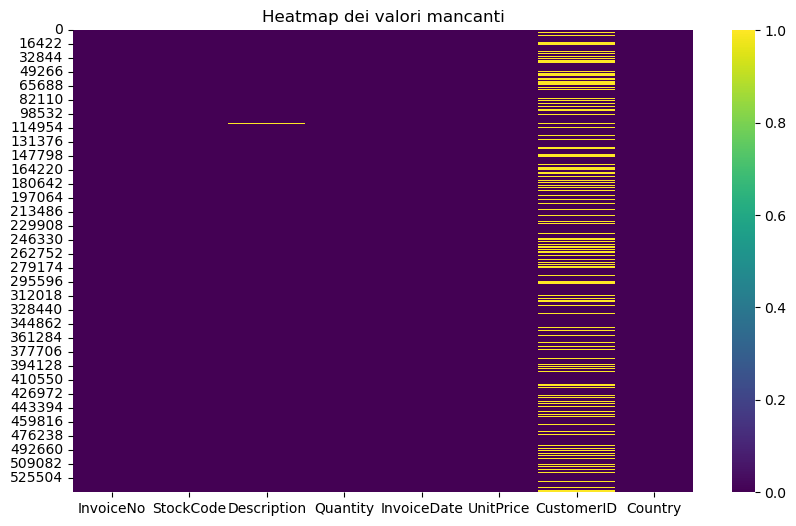

In [55]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=True, cmap='viridis')
plt.title('Heatmap dei valori mancanti')
plt.show()

<h4><b>Spiegazione grafico:</b></h4>
<ul>
    <li>Nell'asse x abbiamo le colonne del dataset: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID e Country</li>
    <li>Nell'asse y abbiamo le righe del dataset</li>
    <li>I colori chiari indicano la presenza di un valore mancante in una determinata cella, che è l'incrocio tra una riga e una colonna</li>
    <li>I colori scuri indicano che il valore invece è presente</li>
</ul>

<p><b>Interpretazione grafico:</b></p>
<ul>
    <li>Le colonne InvoiceNo, StockCode, Quantity, InvoiceDate, Country e UnitPrice non presentano apparentemente valori mancanti (sono completamente viola scuro)</li>
    <li>La colonna Description ha alcuni valori mancanti, concentrati in una zona specifica. Questo potrebbe indicare un problema di inserimento dati in un determinato periodo o per specifici prodotti</li>
    <li>La colonna CustomerID mostra una grande quantità di valori mancanti</li>
</ul>

<h4>Controllo Valori Duplicati</h4>

In [56]:
# Controlla e stampa il numero di righe duplicate basate sulle colonne specificate
if df.duplicated(subset=['CustomerID', 'InvoiceDate', 'StockCode', 'Quantity', 'UnitPrice', 'Description', 'Country']).sum() > 0:
    print("Numero di righe duplicate:", df.duplicated(subset=['CustomerID', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Description', 'Country']).sum())
else:
    print("Non ci sono righe duplicate")

Numero di righe duplicate: 6007


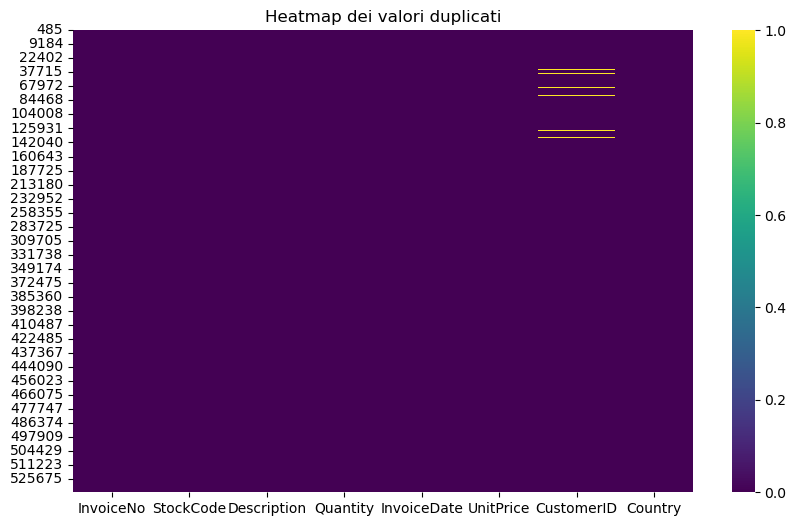

In [57]:
# Trova i duplicati
duplicates = df.duplicated(keep=False)
# Se si mette keep[True] troverà solo la prima occorrenza
# Se si mette keep[False] troverà tutte le occorrenze

# Crea una heatmap dei duplicati
plt.figure(figsize=(10, 6))
sns.heatmap(df[duplicates].isnull(), cbar=True, cmap='viridis')
plt.title('Heatmap dei valori duplicati')
plt.show()

<p><b>Interpretazione grafico:</b></p>
<ul>
    <li>Sono presenti delle celle colorate di giallo che indicano la presenza di valori duplicati nella colonna CustomerID, dovuti forse al fatto che alcuni clienti hanno effettuato più ordini</li>
</ul>

<h4>Verifica Anomalie</h4>

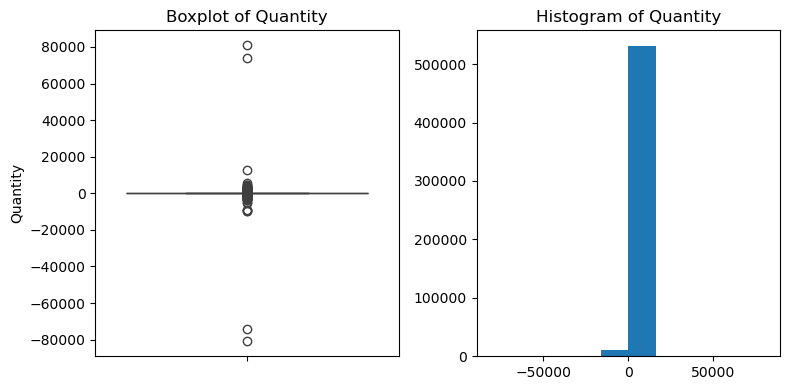

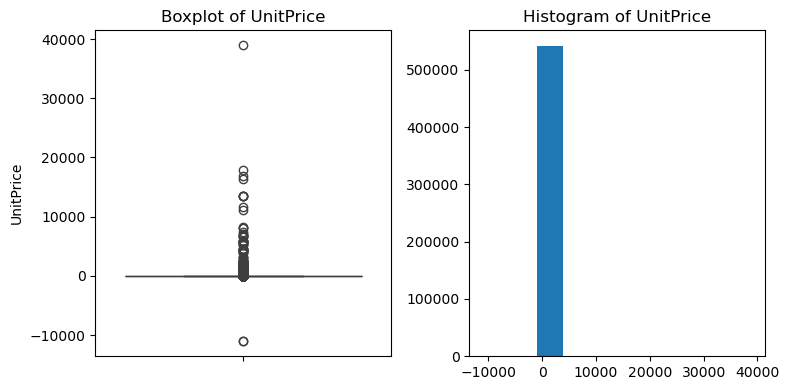

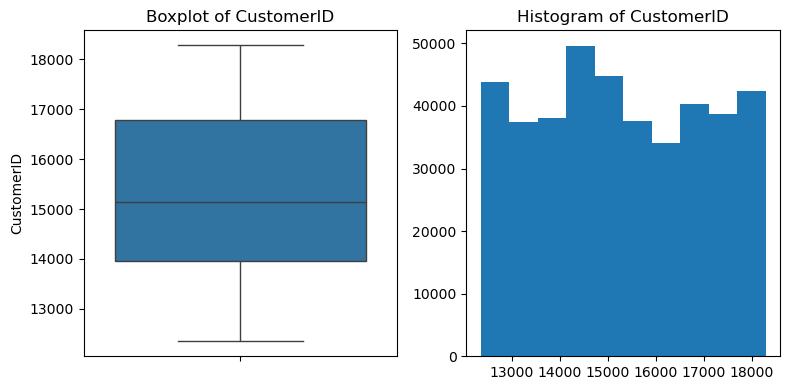

In [58]:
df_numeric = df.select_dtypes(include='number')

for i, col in enumerate(df_numeric.columns):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    sns.boxplot(data=df[col], ax=axs[0])
    axs[0].set_title(f"Boxplot of {col}")
    axs[1].hist(df[col])
    axs[1].set_title(f"Histogram of {col}")
    plt.tight_layout()
    plt.show()

<p><b>Considerazioni:</b></p>
<ul>
    <li>Nei boxplot di Quantity e Unit price non si vedono i baffi. Il motivo è il range estremamente ampio dei valori nell'asse y, che vanno da -80995 a 80995 con moltissimi valori nel mezzo. La scatola e i baffi sono quindi così piccoli da non essere visibili sul grafico per via dei pochi valori nella parte centrale della distribuzione rispetto agli estremi.</li>
    <li>Nella colonna Quantity del dataset il valore massimo è 80995 e il minimo è -80995, è quindi probabile che sia stato effettuato un rimborso dei prodotti acquistati.</li>
    <li>La stessa cosa si vede anche in altri acquisti, ad esempio l'utente con CustomerID 12346.0 risulta aver comprato una quantità pari a 74215 prodotti di "MEDIUM CERAMIC TOP STORAGE JAR", e poi lo stesso utente ha associata una quantità di -74215, dovuta probabilmente a un rimborso.</li>
</ul>

<h4><b>3. Preparazione Dati</b></h4>
<ul>
    <li>Nella colonna UnitPrice sono presenti molte celle con 0.0. Terremo questi valori in quanto è possibile che l'azienda metta ogni tanto dei prodotti in regalo per fidelizzare i clienti. Inoltre questo è coerente con lo scopo delle nostre analisi perchè, capendo quali sono i prodotti più acquistati, capiamo anche quali prodotti l'azienda può mettere ciclicamente in promozione per fidelizzare i clienti.</li>
    <li>Siccome le nostre analisi sono finalizzate ad analizzare il comportamento "tipico" dei clienti, escluderemo i i dati con quantità estreme per concentrarci sull'analisi delle vendite più comuni. Rimuoveremo quindi i dati con quantità a 10000 e inferiore a -10000 considerandoli come valori anomali.</li> 
</ul>

<h4><b>3.1. Pulizia Dati</b></h4>


<h4>Rimozione valori anomali</h4>

In [59]:
# Rimuovi i valori nella colonna 'Quantity' sopra 10000 e sotto -10000
df_cleaned = df[(df['Quantity'] <= 10000) & (df['Quantity'] >= -10000)]

df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<h4>Rimozione valori duplicati</h4>

In [60]:
# Rimuovi le righe duplicate basate su 'CustomerID', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Description', 'Country'
df_cleaned = df.drop_duplicates(subset=['CustomerID', 'InvoiceDate', 'StockCode', 'Quantity', 'UnitPrice', 'Description', 'Country'])

df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<h4><b>3.2. Visualizzazione Dati</b></h4>

<h4>Matrice di correlazione tra Quantità e Prezzo Unitario</h4>

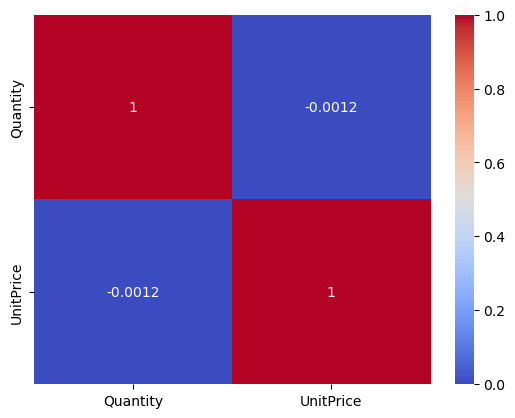

In [61]:
df_bought = df_cleaned[df_cleaned['Quantity'] > 0]

selected_columns = df_cleaned[['Quantity', 'UnitPrice']]

# Calcola la matrice di correlazione per le colonne numeriche
correlation_matrix = selected_columns.corr()

# Crea una heatmap della matrice di correlazione
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Mostra il grafico
plt.show()

<p><b>Considerazioni:</b></p>
<ul>
    <li>Quantity e UnitPrice: -0.0053. Non c'è una correlazione lineare significativa tra la quantità acquistata di un prodotto e il suo prezzo unitario</li>
    <li>Quindi il prezzo del prodotto non influenza la quantità con cui questo prodotto verrà acquistato</li>
</ul>

<h4>Matrice di correlazione tra le diverse categorie di prodotti (considerando i 10 prodotti più venduti)</h4>

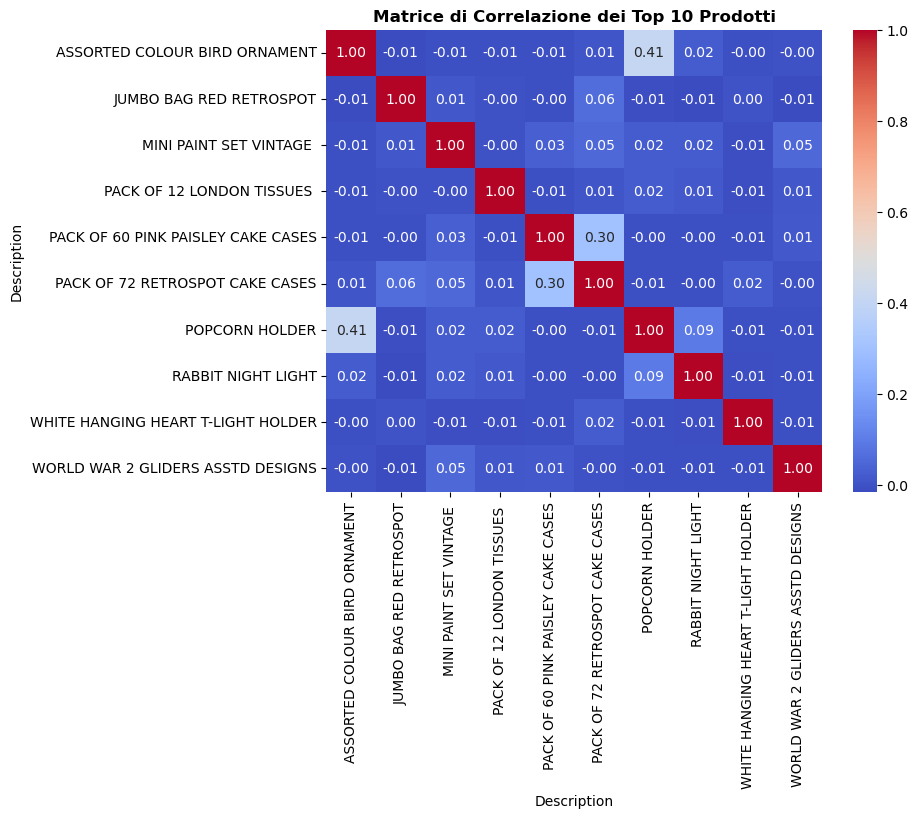

In [62]:
# Extract Top 10 Products by Quantity Sold
top_products = df_cleaned.groupby('Description')['Quantity'].sum().nlargest(10).index
top_products_df = df_cleaned[df_cleaned['Description'].isin(top_products)]

# Calculate Correlation
# Pivot the data to create a matrix of quantities with 'InvoiceNo' as rows and 'Description' as columns
pivot_df = top_products_df.pivot_table(index='InvoiceNo', columns='Description', values='Quantity', aggfunc='sum', fill_value=0)

# Calculate the correlation matrix using the corr() method
correlation_matrix = pivot_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
plt.title('Matrice di Correlazione dei Top 10 Prodotti', fontweight='bold')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

<h4><b>Considerazioni</b></h4>
<ul>
    <li>La maggior parte dei coefficienti di correlazione sono molto vicini a zero, indicando che non esiste una forte relazione lineare tra le vendite dei diversi prodotti</li>
    <li>Gli unici prodotti che mostrano una leggera correlazione positiva sono "assorted colour bird ornament" con "popcorn holder" e i "pink paislay cake cases con i "retrospot cake cases", quindi i prodotti per le feste.</li>
    <li>Non ci sono correlazioni lineari negative significative</li>
    <li>Questo ci fa capire che i clienti tendono ad acquistare i prodotti in modo indipendente</li>
</ul>

<h1><b>4. Costruzione Modello</b></h1>
<h4><b>4.1. Segmentazione Clienti</b></h4>

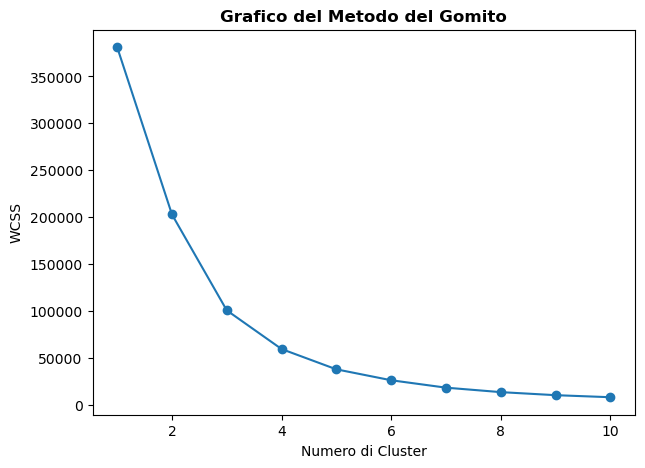

In [63]:
# Filter out cancelled transactions
df_cleaned = df[~df['InvoiceNo'].str.startswith('C', na=False)]

# Aggregate data by CustomerID
customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique'
}).reset_index()

# Rename columns for clarity
customer_df.columns = ['CustomerID', 'NumOrders']

# Prepare data for KMeans
X = customer_df[['NumOrders']]

# Determine the optimal number of clusters using the elbow method
wcss = [] # @todo Che cosa é il WCSS
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(7, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Grafico del Metodo del Gomito', fontweight='bold')
plt.xlabel('Numero di Cluster')
plt.ylabel('WCSS')
plt.show()

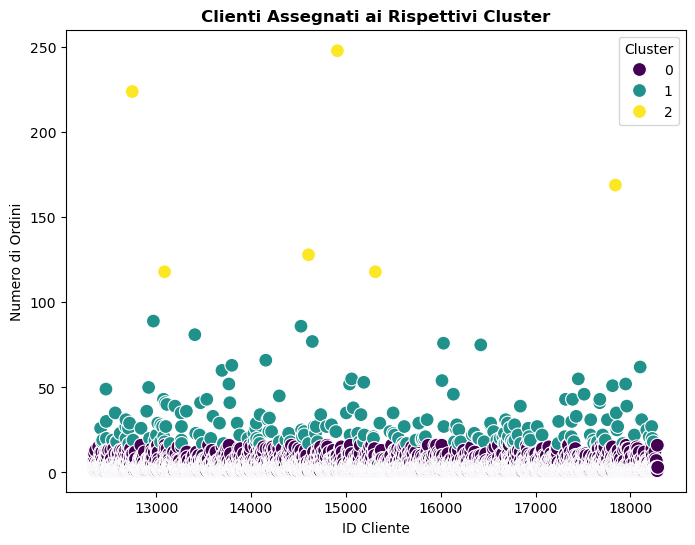

In [64]:
# Apply KMeans with the optimal number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(X)

# Merge the cluster information back to the original dataframe
df_clustered = df_cleaned.merge(customer_df[['CustomerID', 'Cluster']], on='CustomerID')

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_df, x='CustomerID', y='NumOrders', hue='Cluster', palette='viridis', s=100)
plt.title('Clienti Assegnati ai Rispettivi Cluster', fontweight='bold')
plt.xlabel('ID Cliente')
plt.ylabel('Numero di Ordini')
plt.legend(title='Cluster')
plt.show()

<h4><b>Spiegazione Grafico</b></h4>
<ul>
    <li>Sull'asse x troviamo tutti gli ID dei Clienti</li>
    <li>Sull'asse y leggiamo il numero di ordini effettuati da ciascun cliente</li>
    <li>I clienti sono stati divisi in 3 cluster:</li>
    <ul>
        <li>Il cluster 0 rappresenta i clienti che hanno effettuato il minor numero di acquisti</li>
        <li>Il cluster 1 rappresenta i clienti che hanno effettuato il maggior numero di acquisti</li>
        <li>Il cluster 2 rappresenta i clienti intermedi, che hanno effettuato tanti ordini, ma non quanto quelli del cluster 1</li>
    </ul>
</ul>
<h4><b>Considerazioni sul Grafico</b></h4>
<ul>
    <li>Per i clienti del Cluster 0 si potrebbe pensare a offerte speciali per invogliarli ad aumentare la loro frequenza di acquisto.</li>
    <li>Per i clienti del Clustter 1 si può pensare di coinvolgerli con programmi di fidelizzazione esclusivi per mantenerli e incentivarli a continuiare ad acquistare.</li>
    <li>Per i clienti del Cluster 2 è possibile creare campagne di marketing mirate per ciascun cliente, offrendo promozioni e incentivi specifici in base ai loro comportamenti di acquisto.</li>
</ul>

In [65]:
# Trova i prodotti più acquistati per ogni cluster
top_products_per_cluster = df_clustered.groupby(['Cluster', 'Description'])['Quantity'].sum().reset_index()

# Ottieni i primi 10 prodotti per ogni cluster
top_products_per_cluster = top_products_per_cluster.sort_values(['Cluster', 'Quantity'], ascending=[True, False]).groupby('Cluster').head(10)

# Funzione per tracciare il grafico a barre
def plot_bar_chart(cluster_data, cluster):
    plt.figure(figsize=(8, 6))
    sns.barplot(data=cluster_data, x='Quantity', y='Description', palette=sns.color_palette("husl", 10))
    plt.title(f'Top Products for Cluster {cluster} - Istogramma', fontweight='bold')
    plt.xlabel('Quantita')
    plt.ylabel('Prodotto')
    plt.tight_layout()
    plt.show()

# Funzione per tracciare il grafico a torta
def plot_pie_chart(cluster_data, cluster):
    plt.figure(figsize=(8, 6))
    cluster_data = cluster_data.set_index('Description')
    cluster_data['Quantity'].plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette("husl", len(cluster_data)))
    plt.title(f'Top 10 Prodotti del Cluster {cluster} - Grafico a Torta', fontweight='bold')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# Funzione per tracciare i grafici a barre raggruppate per mese
def plot_grouped_bar_chart(cluster_monthly_data, cluster):
    cluster_monthly_data = cluster_monthly_data.copy()
    cluster_monthly_data['Month'] = pd.to_datetime(cluster_monthly_data['InvoiceDate']).dt.to_period('M')
    top_products_per_month = cluster_monthly_data.groupby(['Month', 'Description'])['Quantity'].sum().reset_index()
    top_products_per_month = top_products_per_month.sort_values(['Month', 'Quantity'], ascending=[True, False]).groupby('Month').head(5)
    
    # Filtra per l'anno più recente
    recent_year = top_products_per_month['Month'].dt.year.max()
    recent_data = top_products_per_month[top_products_per_month['Month'].dt.year == recent_year]
    
    # Funzione per tracciare i grafici
    def plot_grouped_bar(data, title):
        months = data['Month'].unique()
        for i in range(0, len(months), 4):
            num_colors = len(data[data['Month'].isin(months[i:i+4])]['Description'].unique())
            plt.figure(figsize=(12, 8))
            sns.barplot(data=data[data['Month'].isin(months[i:i+4])], x='Month', y='Quantity', hue='Description', palette=sns.color_palette("tab10", num_colors))
            plt.title(f'{title} - Mesi {months[i]} a {months[min(i+3, len(months)-1)]}', fontweight='bold')
            plt.xlabel('Mese')
            plt.ylabel('Quantita')
            plt.legend(title='Prodotto', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()
    
    # Traccia i grafici per l'anno più recente
    plot_grouped_bar(recent_data, f'Top 5 Prodotti per Mese nel Cluster {cluster} - Anno {recent_year}')

# Funzione per tracciare la distribuzione delle vendite nei vari paesi per cluster
def plot_country_distribution(cluster_data, cluster):
    country_counts = cluster_data['Country'].value_counts()
    percentages = country_counts / country_counts.sum() * 100
    main_countries = percentages[percentages >= 1]
    other_countries = percentages[percentages < 1]
    if other_countries.sum() > 0:
        main_countries['Others'] = other_countries.sum()
    
    plt.figure(figsize=(8, 6))
    main_countries.plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette("husl", len(main_countries)))
    
    if other_countries.sum() > 0:
        others_label = '\n'.join([f'{country} - {percentage:.1f}%' for country, percentage in other_countries.items()])
        plt.legend([f'Others:\n{others_label}'], loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.title(f'Distribuzione delle Vendite nei Vari Paesi per Cluster {cluster}', fontweight='bold')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
    
# Funzione per trovare i prodotti più acquistati nei primi 3 paesi dopo il Regno Unito per un cluster specifico
def top_products_top_countries_clustered(df_clustered, cluster):
    # Filtra i dati per il cluster specifico
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
    
    # Escludi il Regno Unito
    cluster_data_excl_uk = cluster_data[cluster_data['Country'] != 'United Kingdom']
    
    # Trova i primi 3 paesi per numero di acquisti
    top_countries = cluster_data_excl_uk['Country'].value_counts().head(3).index
    
    for country in top_countries:
        country_data = cluster_data[cluster_data['Country'] == country]
        top_products = country_data.groupby('Description')['Quantity'].sum().reset_index()
        top_products = top_products.sort_values(by='Quantity', ascending=False).head(10)
        
        plt.figure(figsize=(8, 6))
        sns.barplot(data=top_products, x='Quantity', y='Description', palette=sns.color_palette("husl", 10))
        plt.title(f'Top 10 Prodotti più Acquistati in {country} nel Cluster {cluster}', fontweight='bold')
        plt.xlabel('Quantita')
        plt.ylabel('Prodotto')
        plt.tight_layout()
        plt.show()

<p><b>Considerazioni Grafici Cluster 0:</b></p>

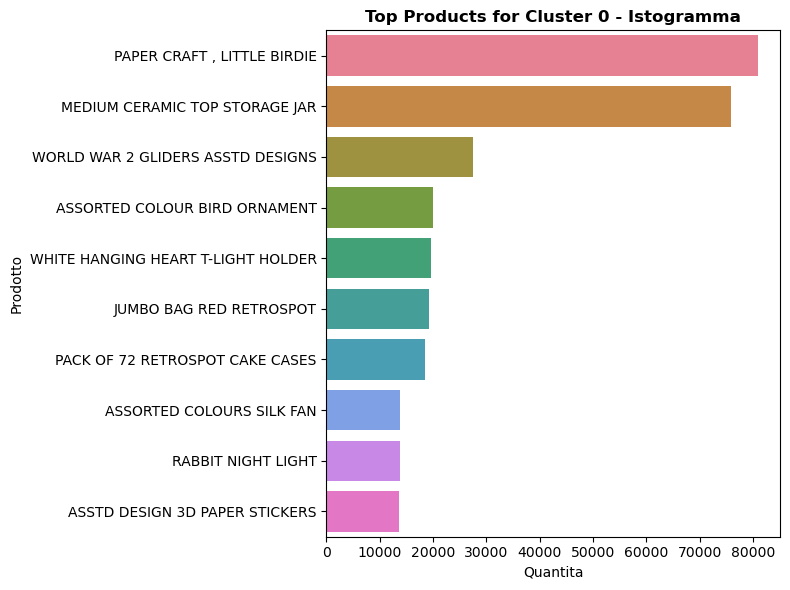

In [66]:
cluster = 0  
cluster_data = top_products_per_cluster[top_products_per_cluster['Cluster'] == cluster]
cluster_monthly_data = df_clustered[df_clustered['Cluster'] == cluster]

plot_bar_chart(cluster_data, cluster)

<p><b>Considerazioni</b></p>
<ul>
    <li>La maggior parte dei prodotti rientra nella categoria di articoli per la casa, articoli decorativi o artigianali. Sono oggetti che possono essere utilizzati per personalizzare gli ambienti o per attività creative</li>
    <li>Alcuni prodotti, come i "Paper Craft, Little Birdie" e gli "Assorted Design 3D Paper Stickers", suggeriscono un interesse per attività creative e manuali, mentre i Pack of 72 Retrospot Cake Cases sono adatti alla cucina</li>
</ul>

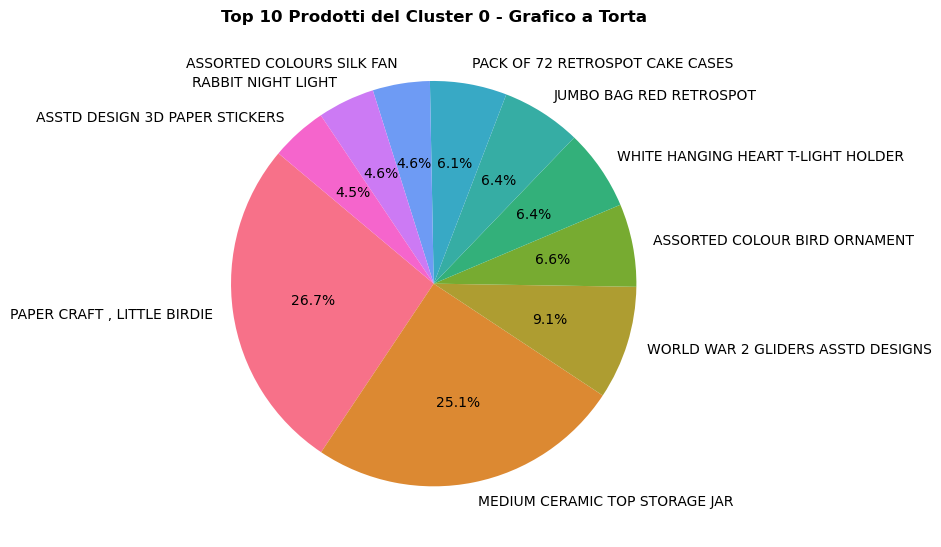

In [67]:
plot_pie_chart(cluster_data, cluster)

<p><b>Considerazioni Grafici Cluster 0 Torta:</b></p>

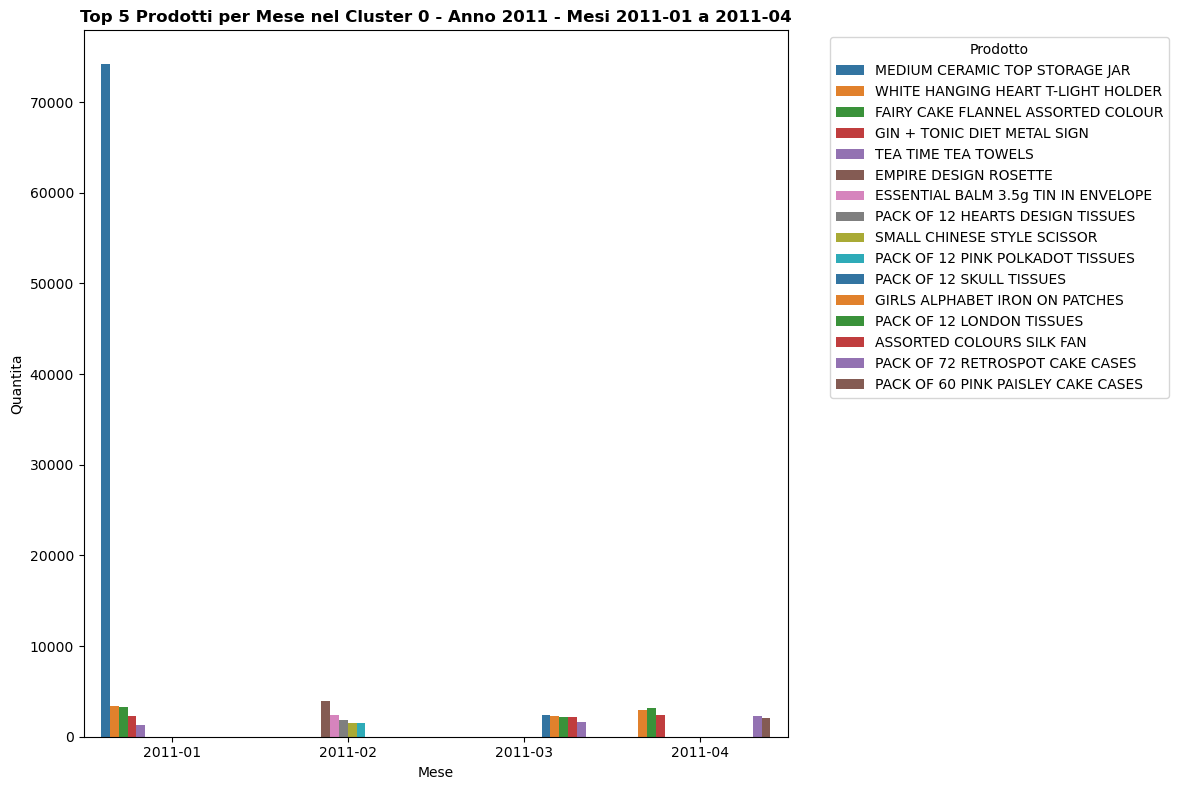

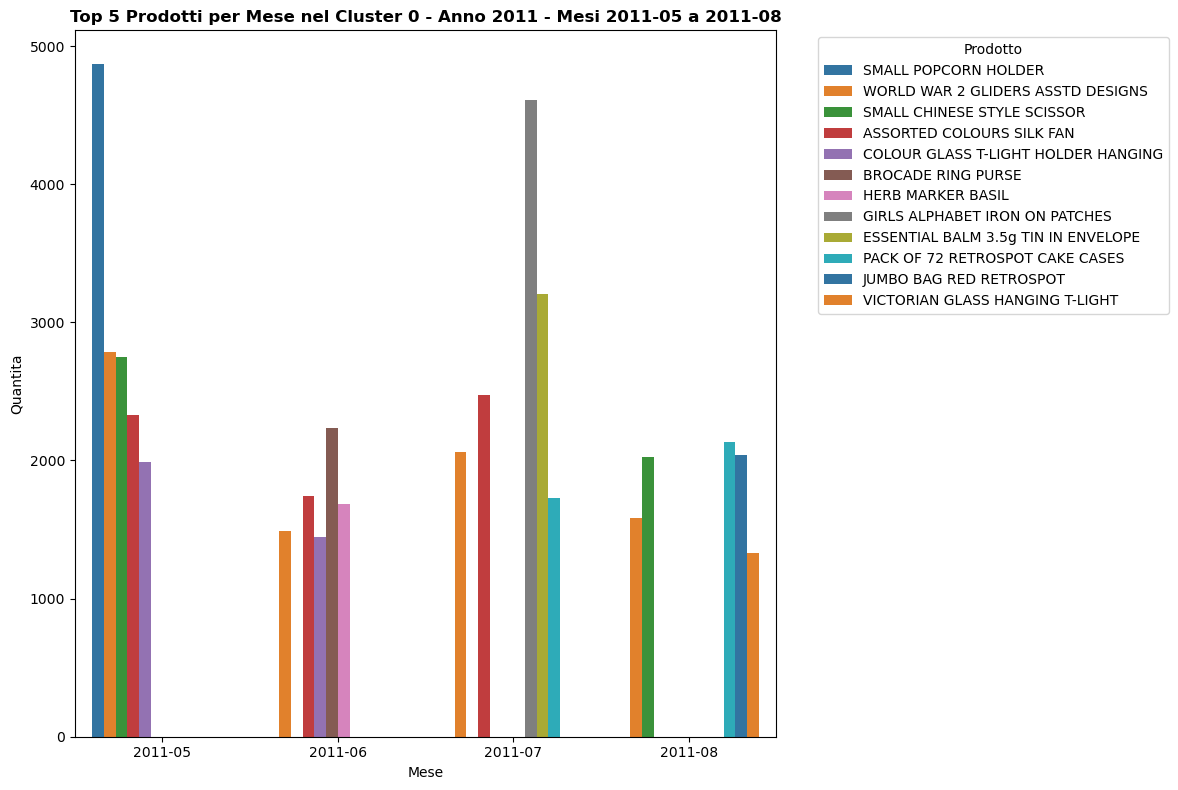

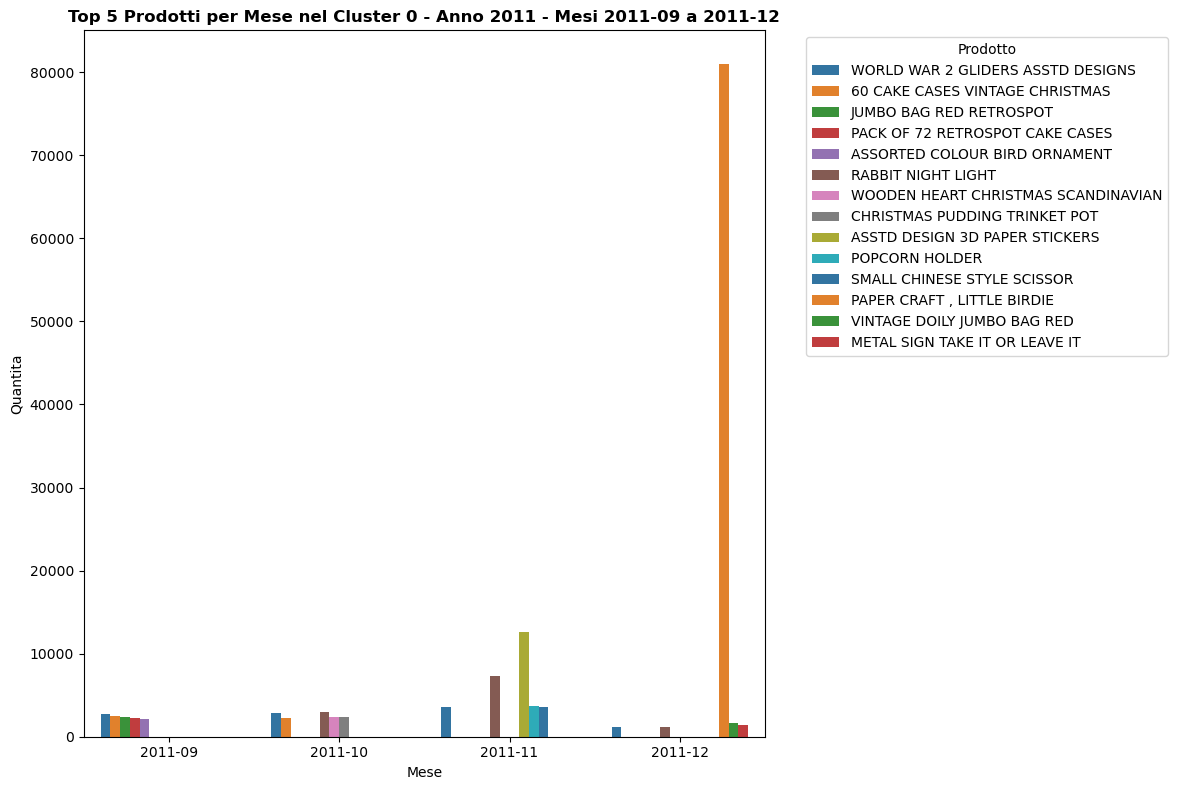

In [68]:
plot_grouped_bar_chart(cluster_monthly_data, cluster)

<p><b>Considerazioni Grafici Cluster 0 Bars Raggruppate:</b></p>
<ul>
    <li>Dopo il picco iniziale di Gennaio col prodotto "MEDIUM CERAMIC TOP STORAGE JAR" (+ di 7000 vendite), osserviamo un drastico calo delle vendite nei mesi successivi fino a Maggio</li>
    <li>Da Maggio in poi le vendite aumentano e presentano i picchi piú significativi a Maggio e Luglio con i prodotti "JUMBO BAG RED RETROSPOT" (circa 5000 vendite) e "GIRLS ALPHABET IRON ON PATCHES" (+ di 4500 vendite)</li>
    <li>Da Settembre in poi le vendite subiscono nuovamente un grosso calo fino all'ultimo picco di Dicembre con "60 CAKE CASES VINTAGE CHRISTMAS" (circa 8000 vendte)</li>
    <li>Tra i prodotti molto venduti nei mesi estivi troviamo "WORLD WAR 2 GLIDERS ASSTD DESIGNERS", che è il prodotto più acquistato dal cluster 1</li>
    <li>L'aumento delle vendite nei mesi estivi potrebbe essere dovuto alle vacanze estive ed essere quindi una stagionalitá, ma questo andrebbe verificato analizzando le vendite negli anni successivi</li>
    <li>Lo stesso ragionamento si puó fare con il picco di dicembre, che potrebbe essere dovuto al periodo natalizio rappresentando anche qui una stagionalitá. In questo caso peró possiamo affermare con piú certezza che si tratta di una stagionalitá perché tra le cose piú comprate troviamo "60 CAKE CASES VINTAGE CHRISTMAS", "PAPER CHAIN KIT 50'S CHRISTMAS" e "WOODEN HEART CHRISTMAS SCANDINAVIAN" e "PAPER CRAFT, LITTLE BIRDIE", ovvero cose natalizie</li>
    <li>I prodotti piú acquistati nei mesi estivi sono "JUMBO BAG RED RETROSPOT", "SMALL POPCORN HOLDER" e "PARTY BUNTING", che sono oggetti spesso usati durante le feste</li>
</ul>

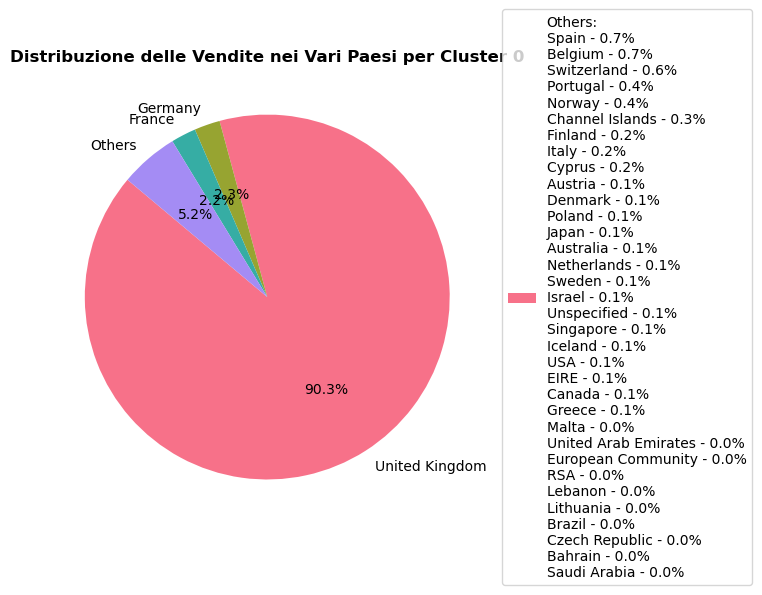

In [69]:
plot_country_distribution(cluster_monthly_data, cluster)

<p><b>Considerazioni Grafici Cluster 0 Country:</b></p>
<ul>
    <li>La maggior parte delle vendite è stata effettuata nel Regno Unito</li>
    <li>Tra tutti gli altri paesi che effettuano acquisti in questo negozio online, quelli in cui vengono effettuati piú acquisti sono Francia e Germania. Per aumentare le vendite in questi due paesi si potrebbero analizzare i prodotti da loro piú acquistati e fare delle offerte specifiche su questi prodotti.</li>
</ul>

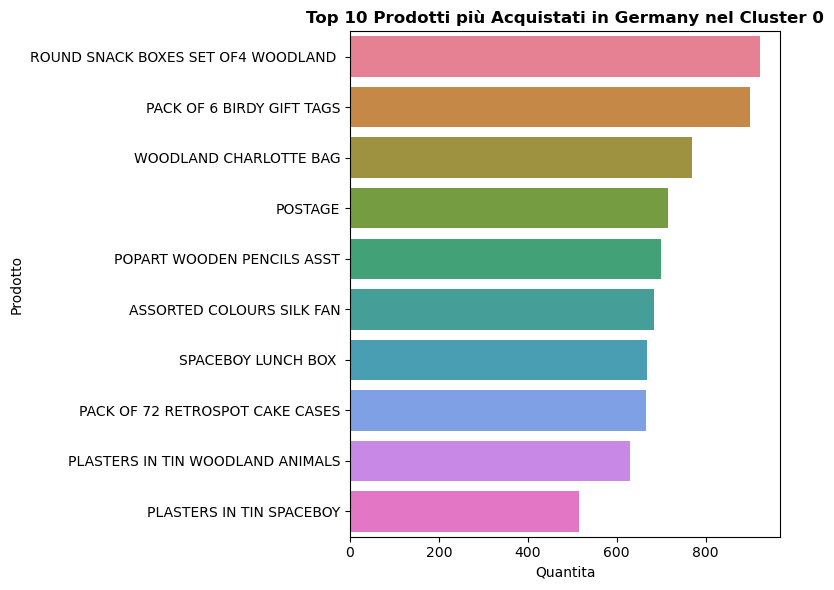

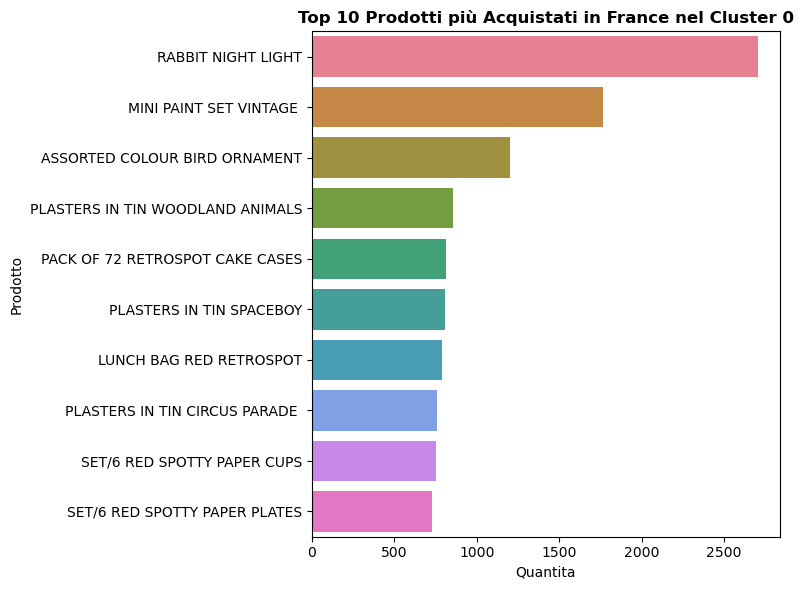

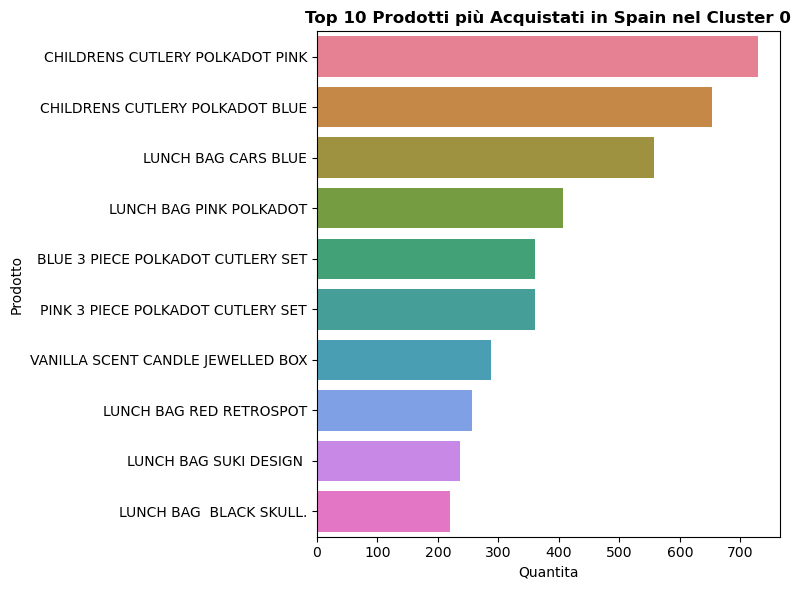

In [70]:
top_products_top_countries_clustered(df_clustered, cluster)

@todo da fare?

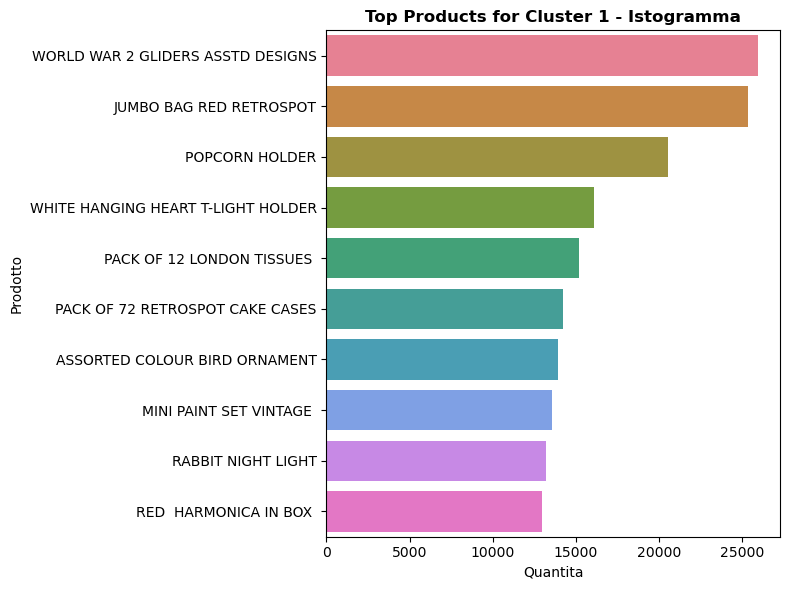

In [71]:
cluster = 1  
cluster_data = top_products_per_cluster[top_products_per_cluster['Cluster'] == cluster]
cluster_monthly_data = df_clustered[df_clustered['Cluster'] == cluster]

plot_bar_chart(cluster_data, cluster)

<p><b>Considerazioni Grafici Cluster 1 Bar:</b></p>
<ul>
    <li>Molti articoli sono oggetti decorativi o da regalo, come il cuore portacandela, gli ornamenti per uccelli, o per lavoretti a mano, nel caso del mini set di pittura vintage</li>
    <li>Il prodotto più venduto è "WORLD WAR 2 GLIDERS ASSTD DESIGNS", ovvero un set di modellini di aerei della Seconda Guerra Mondiale, che potrebbe essere un giocattolo o un gadget da collezione</li>
</ul>

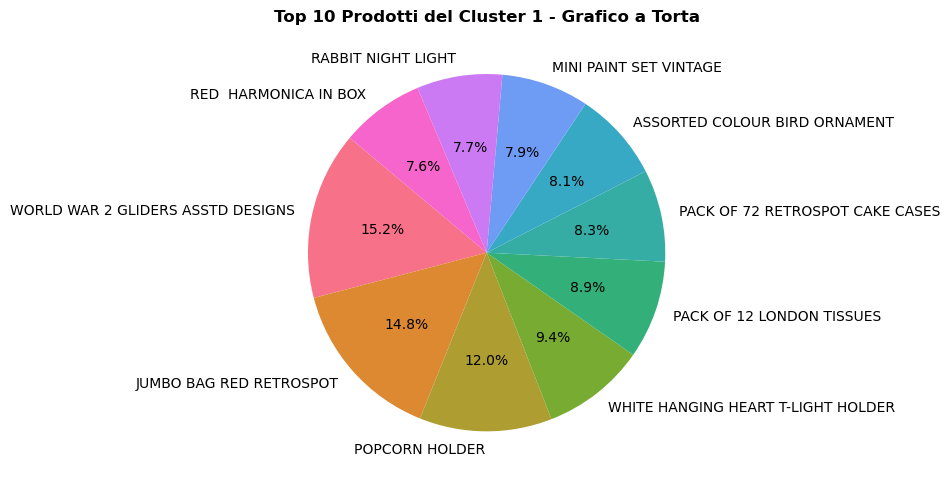

In [72]:
plot_pie_chart(cluster_data, cluster)

<p><b>Considerazioni Grafici Cluster 1 Torta:</b></p>

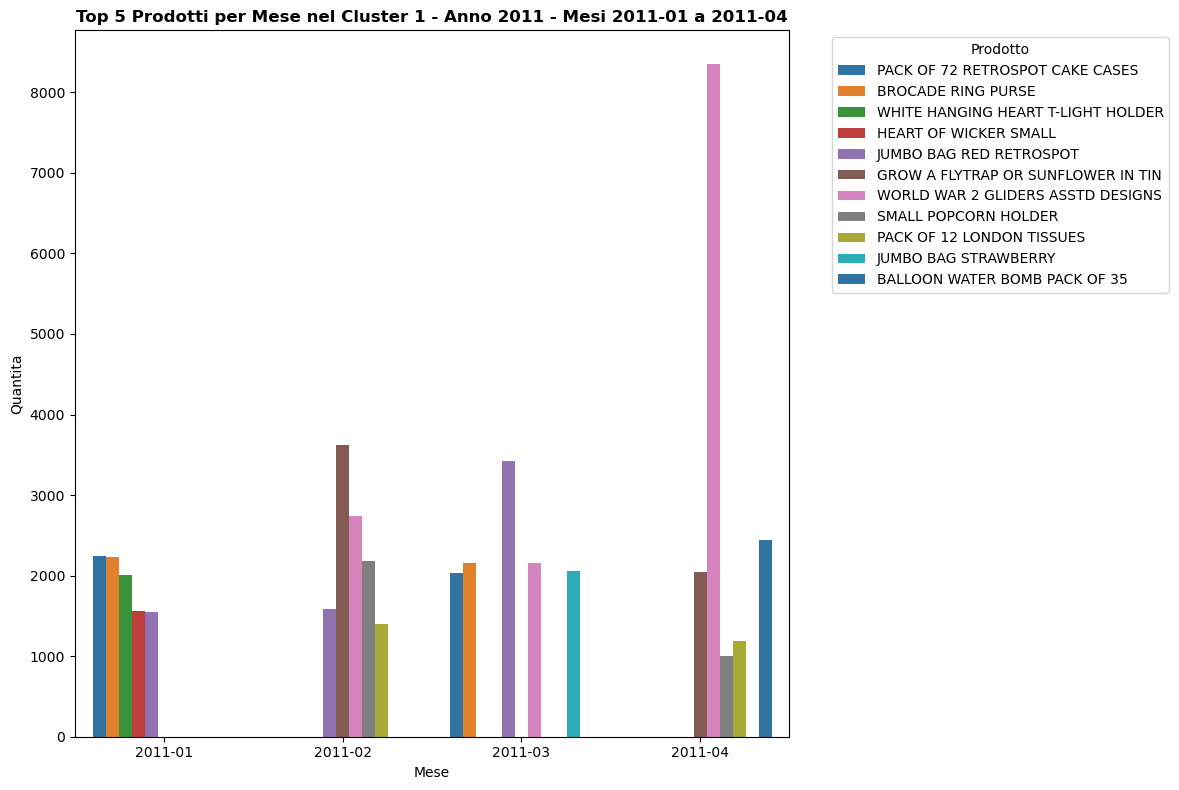

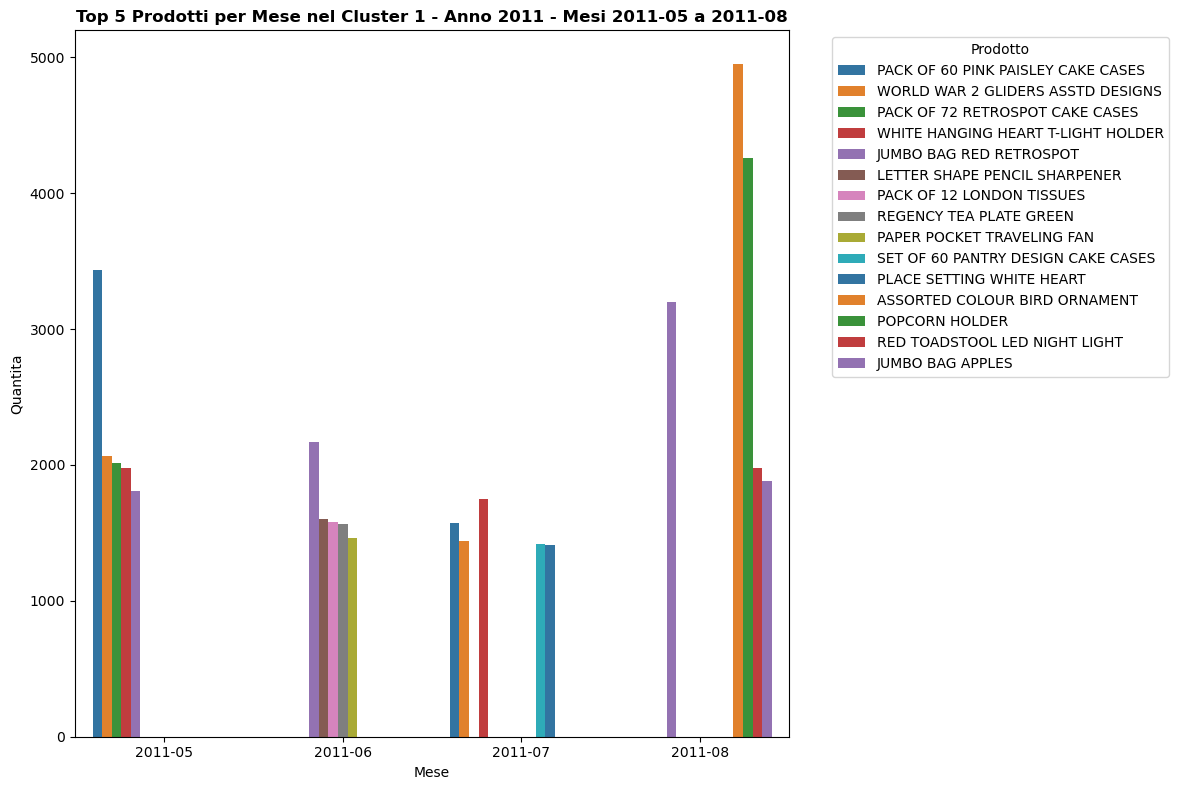

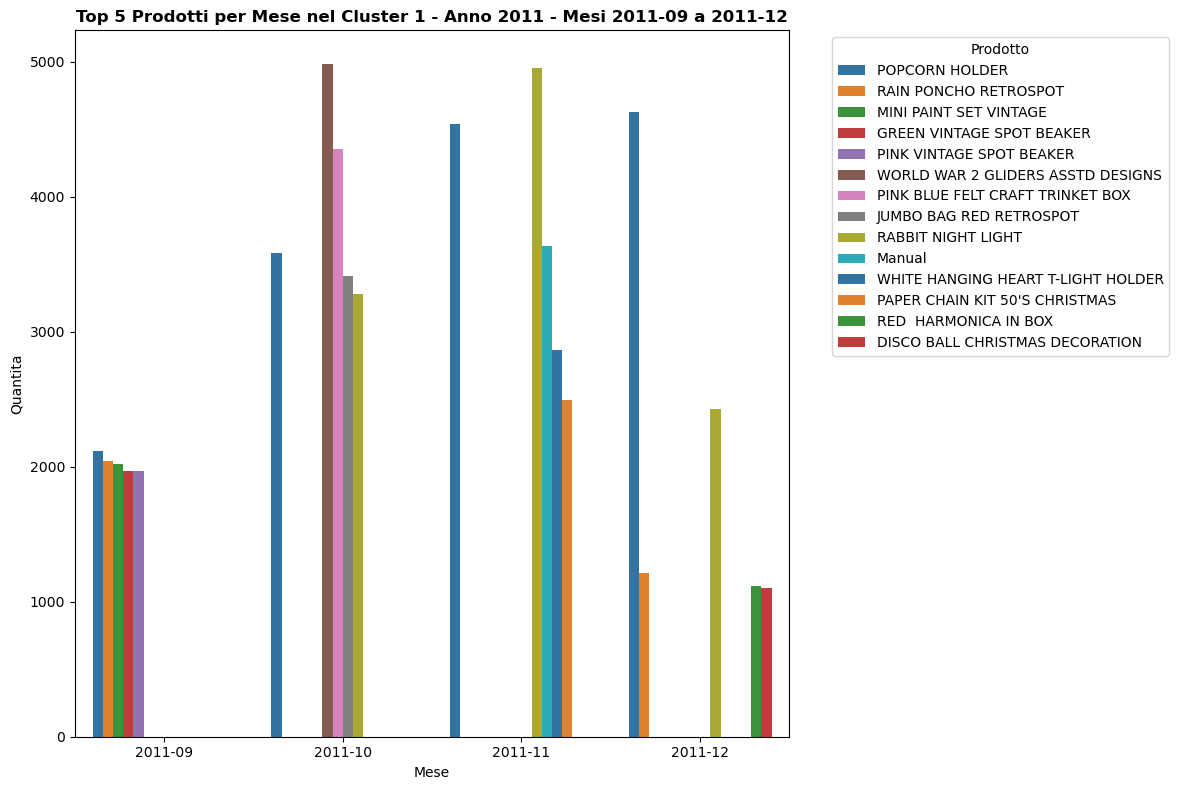

In [73]:
plot_grouped_bar_chart(cluster_monthly_data, cluster)

<p><b>Considerazioni Grafici Cluster 1 Bars Raggruppate:</b></p>
<ul>
    <li>Nei primi mesi dell'anno notiamo un picco significativo ad Aprile, con il prodotto "WORLD WAR 2 GLIDERS ASSTD DESIGNERS" (+ 8000 venduti)</li>
    <li>Successivamente, nei mesi che vanno da Maggio ad Agosto, notiamo un leggero picco ad Agosto, in cui troviamo sempre il prodotto "WORLD WAR 2 GLIDERS ASSTD DESIGNERS" come il più venduto (circa 5000 venduti)</li>
    <li>Infine, negli ultimi mesi dell'anno, le vendite raggiungono il vertice massimo nei mesi di Ottobre e Novembre con i prodotti "WORLD WAR 2 GLIDERS ASSTD DESIGNERS" e "RABBIT NIGHT LIGHT", che risultano essere i due più venduti (circa 5000), seguiti dal "WHITE HANGING HEART LIGHT HOLDER". Questi picchi però, non raggiungono la stessa quantità di vendite del picco di Aprile. Notiamo la persistenza di "WORLD WAR 2 GLIDERS ASSTD DESIGNERS" tra i prodotti più venduti.</li>
    <li>"WORLD WAR 2 GLIDERS ASSTD DESIGNERS" è il prodotto più venduto per tutto l'anno, suggerendo un interesse da parte dei clienti di questo cluster per la storia legata alla seconda guerra mondiale</li>
</ul>

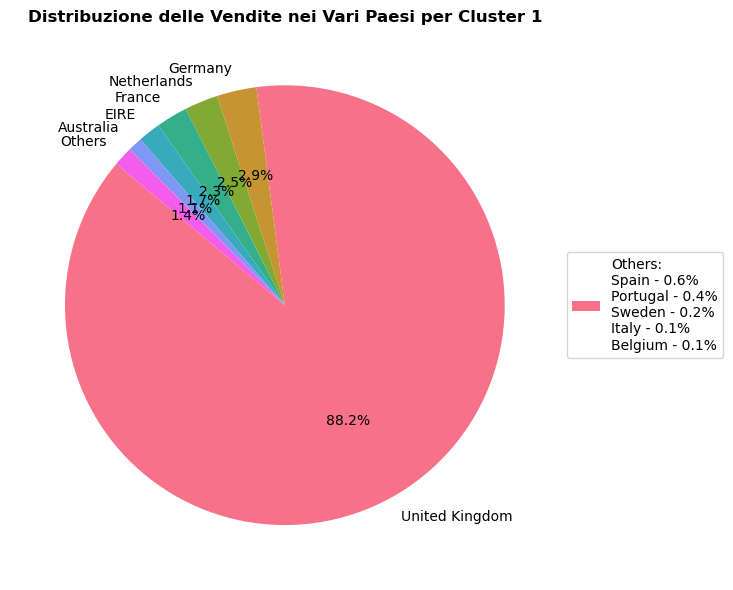

In [74]:
plot_country_distribution(cluster_monthly_data, cluster)

<h4><b>Considerazioni:</b></h4>
<ul>
    <li>Come nel cluster 0, anche nel cluster 1 la maggior parte di acquisti sono stati fatti nel Regno unito. Analizziamo quali sono i prodotti più comprati negli altri paesi per attuare delle strategie di marketing specifiche per ogni paese.</li>
</ul>

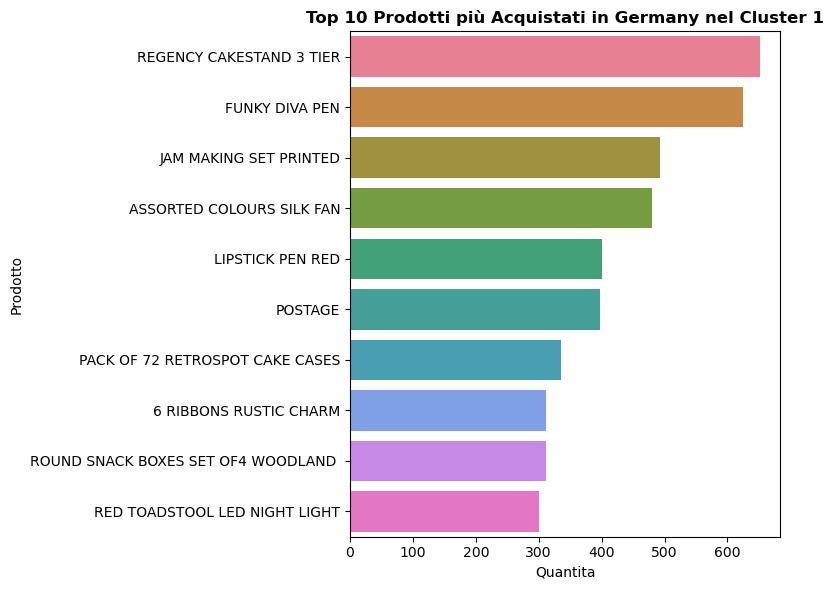

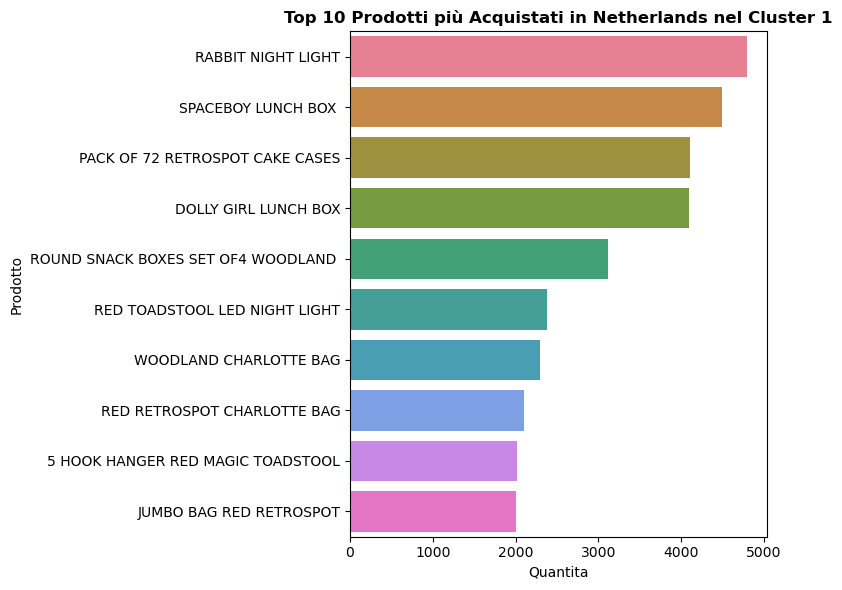

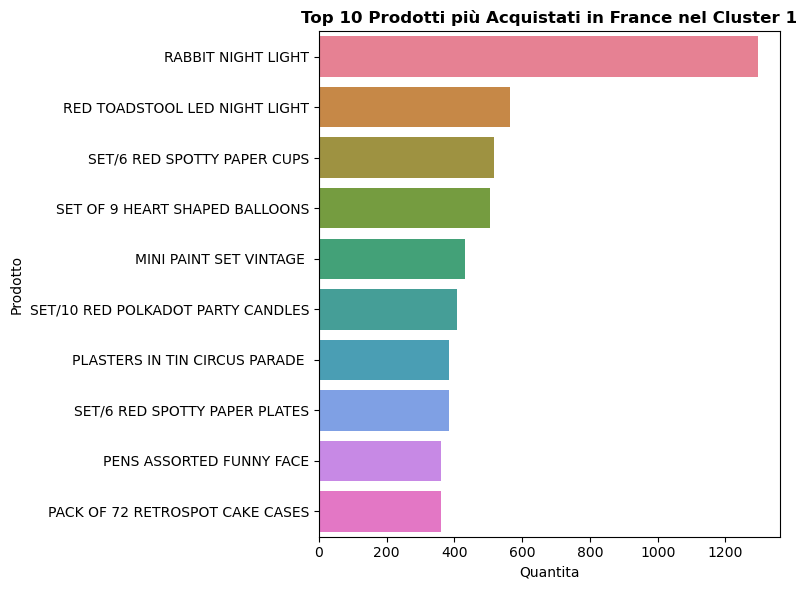

In [75]:
top_products_top_countries_clustered(df_clustered, cluster)

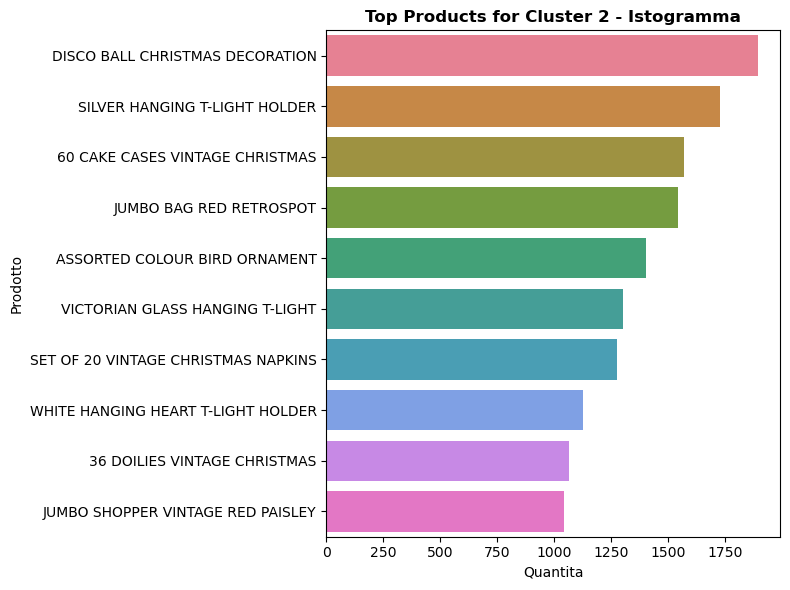

In [76]:
cluster = 2  
cluster_data = top_products_per_cluster[top_products_per_cluster['Cluster'] == cluster]
cluster_monthly_data = df_clustered[df_clustered['Cluster'] == cluster]

plot_bar_chart(cluster_data, cluster)

<p><b>Considerazioni Grafici Cluster 2 Bars:</b></p>
<ul>
    <li>La categoria predominante in questo cluster è quella degli articoli e decorazioni per la casa in tema Natalizio</li>
</ul>

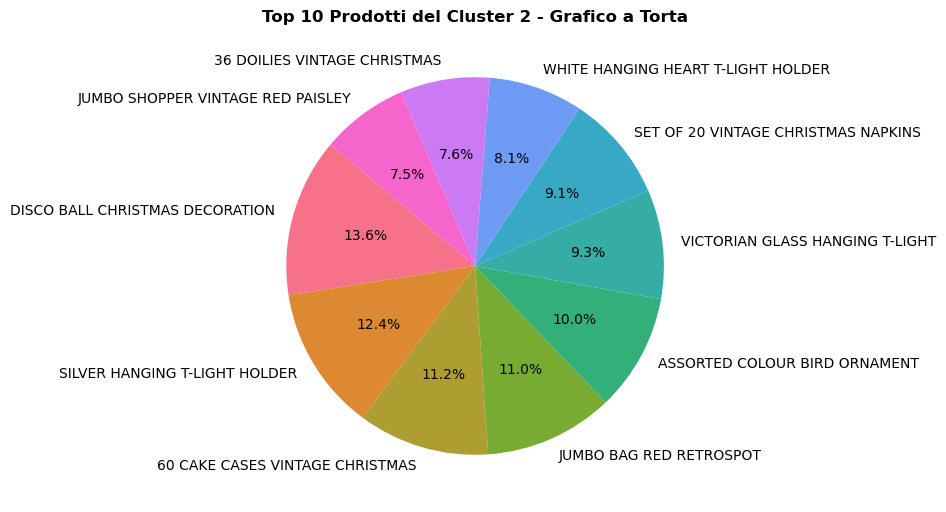

In [77]:
plot_pie_chart(cluster_data, cluster)

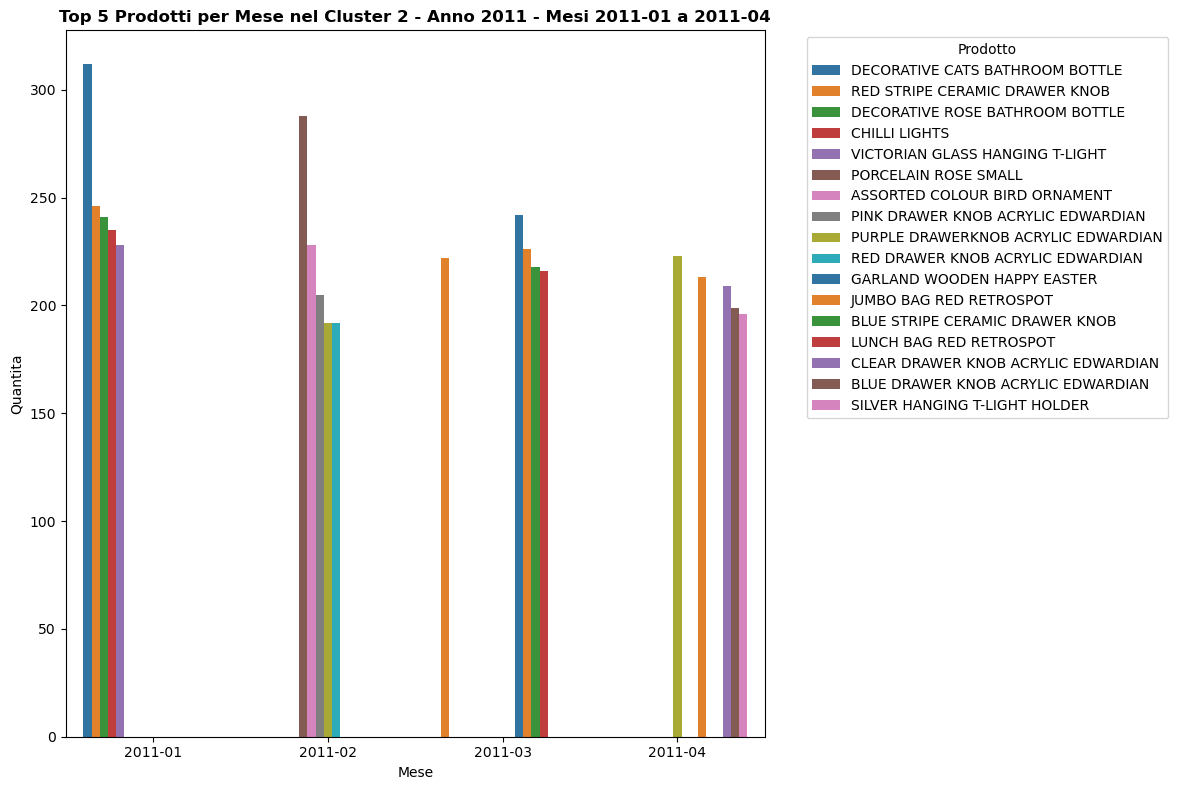

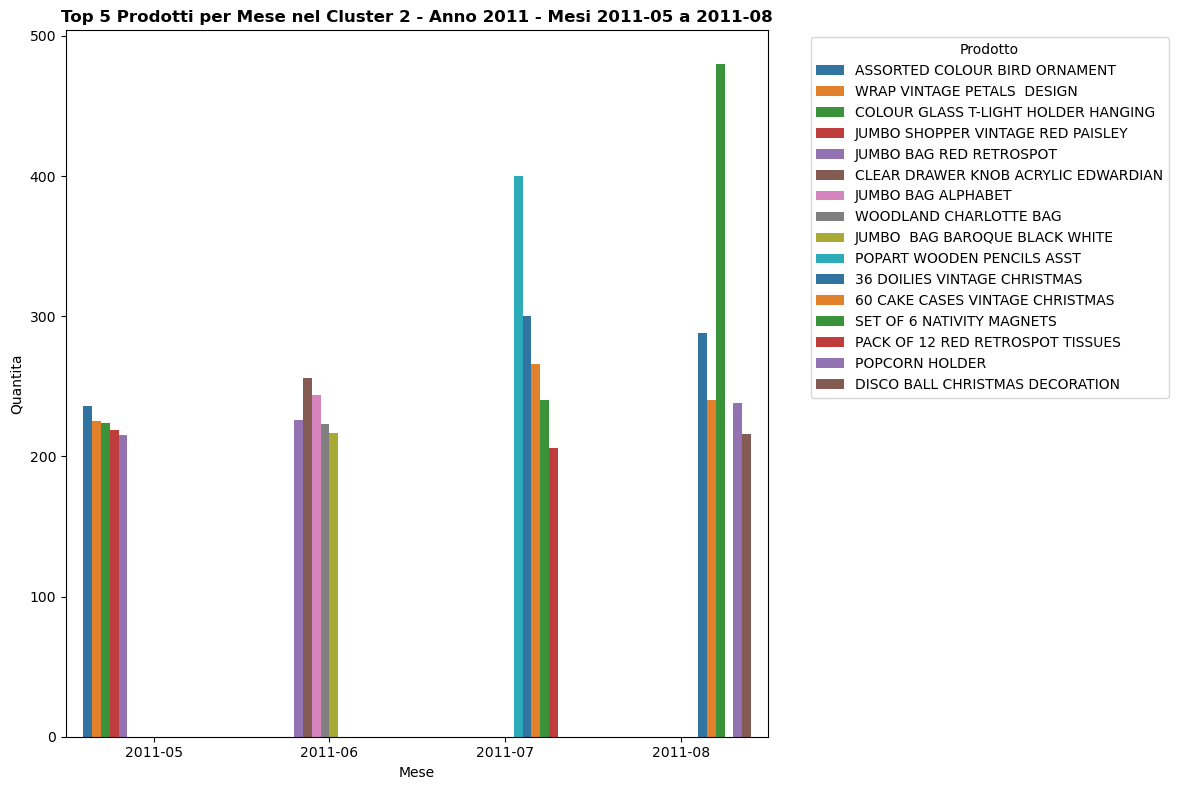

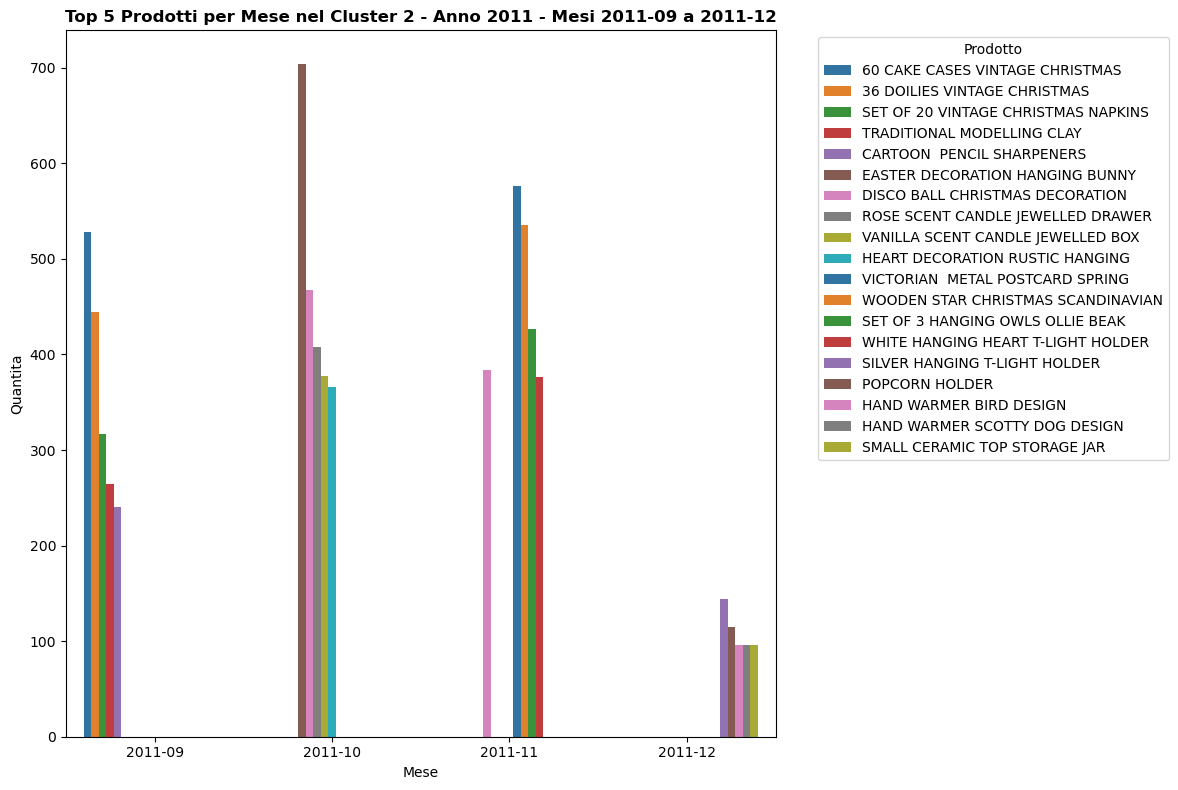

In [78]:
plot_grouped_bar_chart(cluster_monthly_data, cluster)

<p><b>Considerazioni Grafici Cluster 2 Bar Raggruppate:</b></p>
<ul>
    <li>Nei primi mesi dell'anno notiamo una certa stabilità delle vendite, non ci sono picchi particolarmente elevati o cali significativi</li>
    <li>Nei mesi di Maggio e Giugno notiamo un calo delle vendite con una ripresa a Luglio col prodotto "POPART WOODEN PENCILS ASST" (circa 400 venduti) e ad Agosto con il prodotto "SET OF 6 NATIVITY MAGNETS" (circa 500 venduti)</li>
    <li>Gli ultimi mesi dell'anno sono quelli in cui si registra il maggior numero di vendite, con un picco significativo a Ottobre con "EASTER DECORATION HANGING BUNNY", seguito da un successivo calo a novembre, fino ad arrivare a dicembre con il minor numero di acquisti per questo cluster</li>
    <li>A differenza del cluster 1, in cui emerge il prodotto "WORLD WAR 2 GLIDERS ASSTD DESIGNERS" come il più venduto, in questo cluster non c'è un prodotto venduto significativamente più degli altri. Questo indica una maggiore diversificazione degli interessi da parte dei clienti</li>
    <li>I prodotti più acquistati in questo cluster sono prodotti per personalizzare e decorare la propria casa, quindi se volessimo fare delle offerte per far aumentare il numero di acquisti da parte dei clienti di questo cluster dovremmo puntare su questi prodotti</li>
</ul>

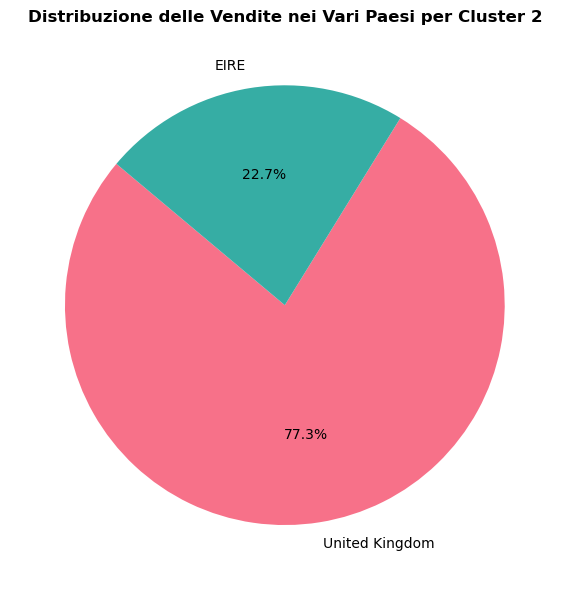

In [79]:
plot_country_distribution(cluster_monthly_data, cluster)

<p><b>Considerazioni Grafici Cluster 2 Contry Distribution:</b></p>
<p>In questo caso, a differenza degli altri due cluster, c'è meno diversificazione tra i paesi che effettuano acquisti in questo negozio online</p>

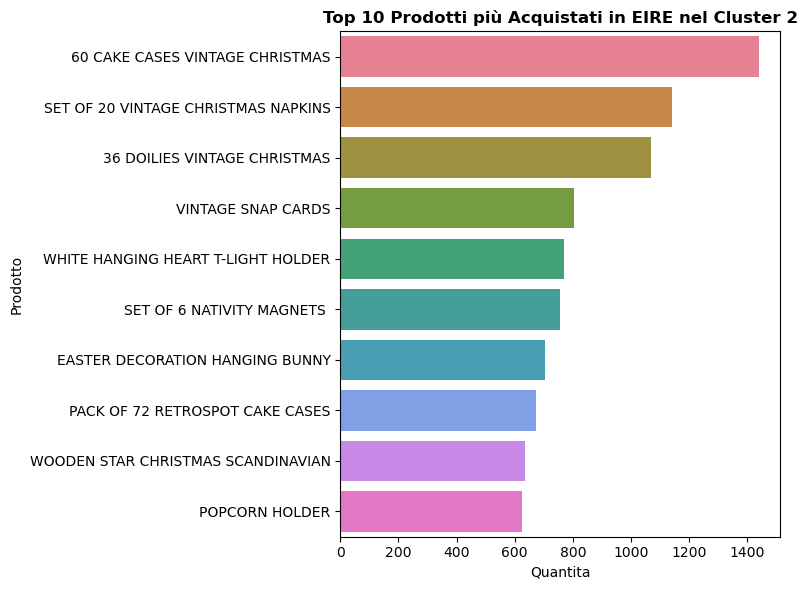

In [80]:
top_products_top_countries_clustered(df_clustered, cluster)

<p>Grafico a Torta dei 10 Prodotti Piú Comprati/Rimborsati</p>

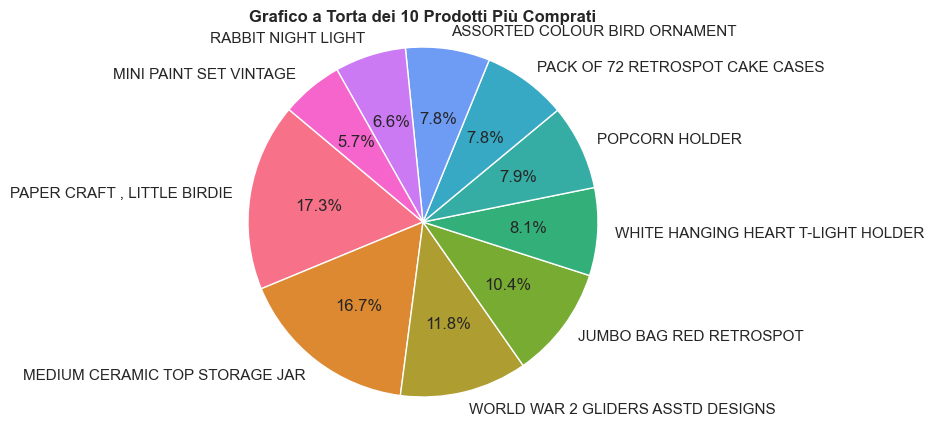

In [81]:
product_sales = df_bought.groupby('Description')['Quantity'].sum()

# Seleziona i 10 prodotti più comprati
top_10_products = product_sales.nlargest(10)

# Visualizza il grafico a torta utilizzando seaborn
plt.figure(figsize=(7, 5))
sns.set(style="whitegrid")
top_10_products.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette("husl", 10))
plt.title('Grafico a Torta dei 10 Prodotti Più Comprati', fontweight='bold')
plt.ylabel('')  # Rimuove l'etichetta dell'asse y
plt.axis('equal')  # Assicura che il grafico a torta sia disegnato come un cerchio
plt.show()

<p>Grafico a Torta dei 10 Prodotti Meno Comprati</p>

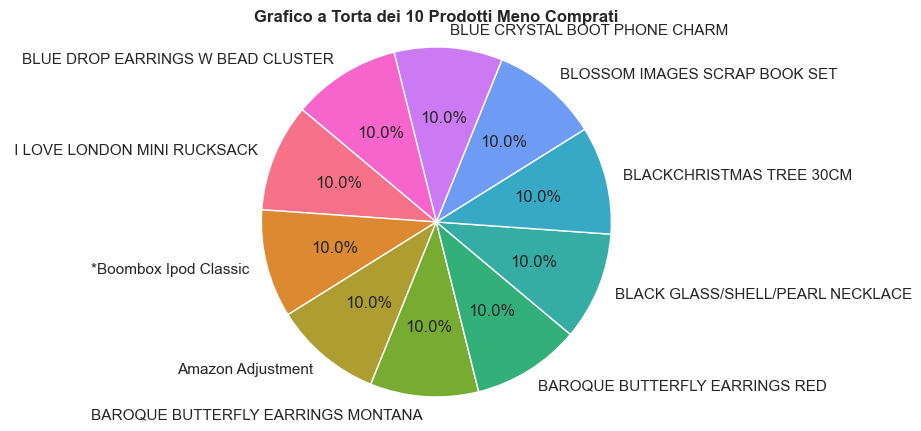

In [82]:
# Seleziona i 10 prodotti meno comprati
bottom_10_products = product_sales.nsmallest(10)

# Visualizza il grafico a torta utilizzando seaborn
plt.figure(figsize=(7, 5))
bottom_10_products.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette("husl", 10))
plt.title('Grafico a Torta dei 10 Prodotti Meno Comprati', fontweight='bold')
plt.ylabel('')  # Rimuove l'etichetta dell'asse y
plt.axis('equal')  # Assicura che il grafico a torta sia disegnato come un cerchio
plt.show()

<h4>Grafico a torta della percentuale di acquisti per ogni paese</h4>

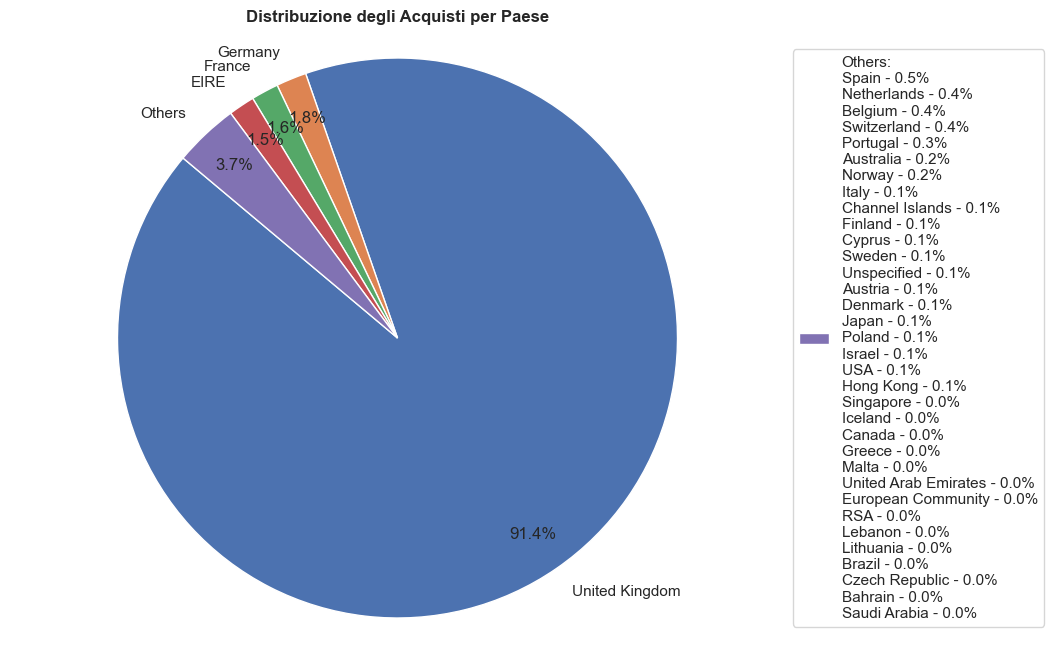

In [83]:
# Raggruppa per paese e conta il numero di acquisti
country_counts = df['Country'].value_counts()

# Calcola le percentuali
percentages = country_counts / country_counts.sum() * 100

# Separa i paesi con percentuali >= 1% e < 1%
main_countries = percentages[percentages >= 1]
other_countries = percentages[percentages < 1]

# Aggiungi una fetta "Others" per i paesi con percentuali < 1%
main_countries['Others'] = other_countries.sum()

# Crea il grafico a torta
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(main_countries, labels=main_countries.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85, labeldistance=1.1)

# Aggiungi la legenda per i paesi nella fetta "Others"
others_label = '\n'.join([f'{country} - {percentage:.1f}%' for country, percentage in other_countries.items()])
plt.legend([wedges[-1]], [f'Others:\n{others_label}'], loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Distribuzione degli Acquisti per Paese', fontweight='bold')
plt.axis('equal')  # Assicura che il grafico sia un cerchio
plt.show()

<h4>Considerazioni</h4>
<p>Questo grafico ci conferma ciò che abbiamo visto nei precedenti grafici sulla distribuzione di acquisti per paese. Il paese che effettua più acquisti è il Regno Unito, seguito da EIRE, Francia e Germania, che effettuano un numero molto minore di acquisti.</p>

<h4><b>4.1. Addestramento Modello</b></h2>

In [84]:
def preprocess_data(df):
    df_daily = df.groupby(df['InvoiceDate'].dt.date).agg({'Quantity': 'sum'}).reset_index()
    df_daily.columns = ['Date', 'Quantity']
    df_daily['Date'] = pd.to_datetime(df_daily['Date'])
    df_daily.set_index('Date', inplace=True)
    return df_daily

def add_time_features(df):
    df['Day'] = df.index.day
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['DayOfWeek'] = df.index.dayofweek
    return df

def add_lag_features(df, lags=7):
    for lag in range(1, lags + 1):
        df[f'Lag_{lag}'] = df['Quantity'].shift(lag)
    return df

def add_rolling_means(df, windows=[7, 14]):
    for window in windows:
        df[f'Rolling_Mean_{window}'] = df['Quantity'].rolling(window=window).mean()
    return df

def add_diff_features(df, diffs=[1, 7]):
    for diff in diffs:
        df[f'Diff_{diff}'] = df['Quantity'].diff(diff)
    return df

def remove_nan(df):
    return df.dropna()

def split_data(df, train_ratio=0.8):
    train_size = int(len(df) * train_ratio)
    train, test = df[:train_size], df[train_size:]
    return train, test

def scale_data(train, test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train)
    X_test_scaled = scaler.transform(test)
    return X_train_scaled, X_test_scaled, scaler

def define_model():
    model = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False]
    }
    return model, param_grid

def perform_grid_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search

def plot_results(results):
    results = results.sort_values(by='mean_test_score', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results, x=results.index, y='mean_test_score', label='Accuratezza Media')
    plt.xlabel('Test Parametri')
    plt.ylabel('Accuratezza Media')
    plt.title('Risultati della Ricerca degli Iperparametri')
    plt.legend()
    plt.show()

def plot_forecast(train, test, forecast):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=train.reset_index(), x='Date', y='Quantity', label='Training')
    sns.lineplot(data=test.reset_index(), x='Date', y='Quantity', label='Test')
    sns.lineplot(data=forecast.reset_index().rename(columns={forecast.index.name: 'Date'}), x='Date', y='Quantity', label='Previsione')
    plt.xlabel('Data')
    plt.ylabel('Quantità')
    plt.title('Previsione delle Vendite con RandomForest')
    plt.legend()
    plt.show()

def plot_future_forecast(df_daily, future_forecast):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_daily.reset_index(), x='Date', y='Quantity', label='Dati Storici')
    sns.lineplot(data=future_forecast.reset_index().rename(columns={future_forecast.index.name: 'Date'}), x='Date', y='Quantity', label='Previsione Futura')
    plt.xlabel('Data')
    plt.ylabel('Quantità')
    plt.title('Previsione Futura delle Vendite con RandomForest')
    plt.legend()
    plt.show()

def plot_benchmarks(y_test, previsioni_media, previsioni_naive):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=y_test.reset_index(), x='Date', y='Quantity', label='Test')
    sns.lineplot(data=pd.DataFrame({'Date': y_test.index, 'Quantity': previsioni_media}).reset_index(drop=True), x='Date', y='Quantity', label='Previsioni Media', linestyle='--')
    sns.lineplot(data=pd.DataFrame({'Date': y_test.index, 'Quantity': previsioni_naive}).reset_index(drop=True), x='Date', y='Quantity', label='Previsioni Naive', linestyle='--')
    plt.xlabel('Data')
    plt.ylabel('Quantità')
    plt.title('Benchmark delle Previsioni')
    plt.legend()
    plt.show()

def plot_benchmark_comparison(benchmark_data):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='RMSE', data=benchmark_data)
    plt.title('Confronto RMSE dei Modelli')
    plt.show()

# Main execution
df_daily = preprocess_data(df_cleaned)
df_daily = add_time_features(df_daily)
df_daily = add_lag_features(df_daily)
df_daily = add_rolling_means(df_daily)
df_daily = add_diff_features(df_daily)
df_daily = remove_nan(df_daily)

train, test = split_data(df_daily)
X_train, y_train = train.drop(columns=['Quantity']), train['Quantity']
X_test, y_test = test.drop(columns=['Quantity']), test['Quantity']

X_train_scaled, X_test_scaled, scaler = scale_data(X_train, X_test)

<h4><b>4.3. Valutazione Modello</b></h2>

Fitting 3 folds for each of 64 candidates, totalling 192 fits


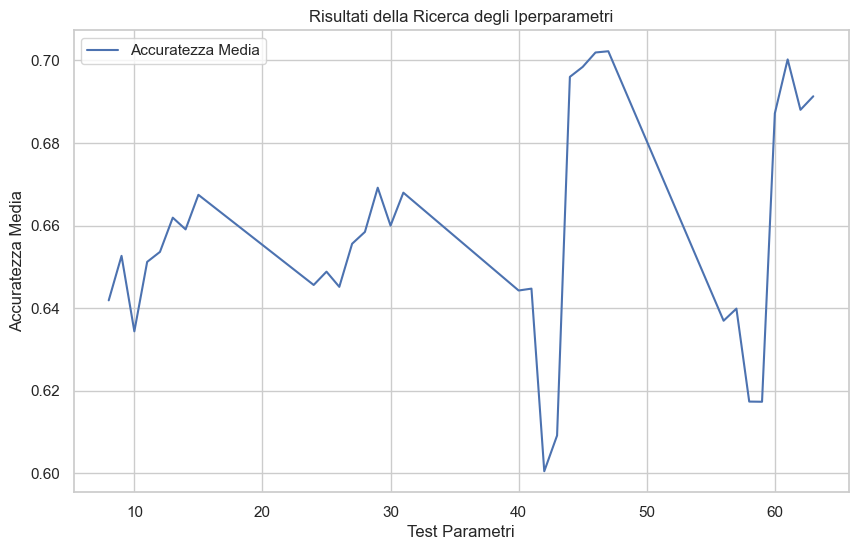

In [85]:
model, param_grid = define_model()
grid_search = perform_grid_search(model, param_grid, X_train_scaled, y_train)

plot_results(pd.DataFrame(grid_search.cv_results_))

<h4><b>Considerazioni:</b></h4>
<ul>
    <li>Il grafico mostra i risultati della ricerca degli iperparametri per un modello di machine learning (Random Forest). Si nota un andamento altalenante del "Accuratezza Media" al variare dei parametri testati. Il picco più alto suggerisce la combinazione di iperparametri che ha portato alle migliori prestazioni del modello.</li>
</ul>

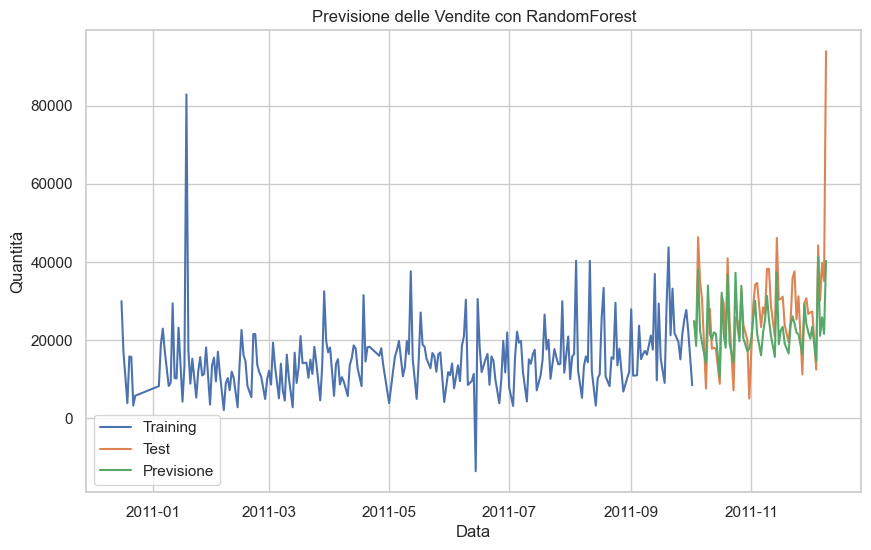

In [86]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

forecast = best_model.predict(X_test_scaled)
forecast = pd.DataFrame(forecast, index=X_test.index, columns=['Quantity'])

rmse = np.sqrt(mean_squared_error(y_test, forecast))

plot_forecast(train, test, forecast)

<h4><b>Considerazioni:</b></h4>
<ul>
    <li>Il grafico mostra l'andamento delle vendite con una forte variabilità, evidenziando un aumento verso la fine del periodo analizzato. Il modello Random Forest prevede bene le tendenze a breve termine ma fatica a catturare i picchi improvvisi.</li>
</ul>

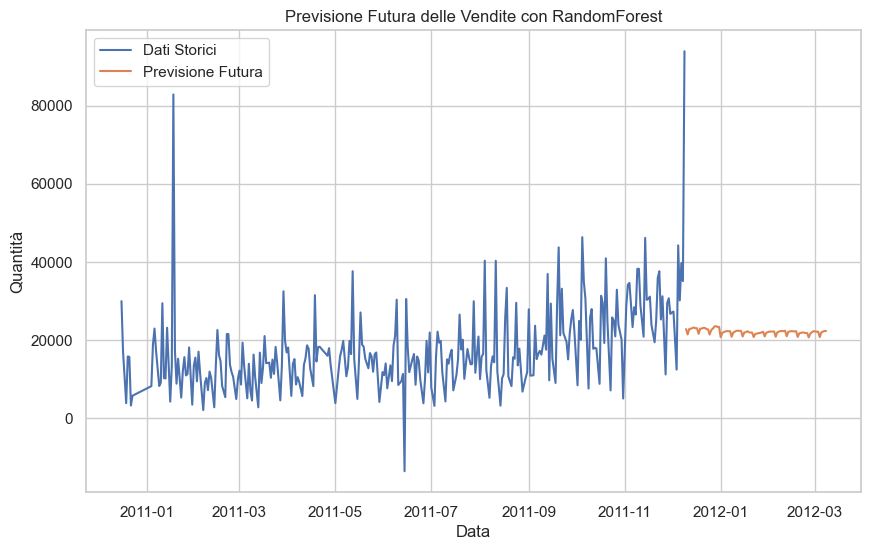

In [87]:
# Future predictions with RandomForest
future_steps = 90
last_date = df_daily.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, inclusive='right')
future_features = pd.DataFrame({
    'Date': future_dates,
    'Day': future_dates.day,
    'Month': future_dates.month,
    'Year': future_dates.year,
    'DayOfWeek': future_dates.dayofweek,
    'Quantity': [df_daily['Quantity'].iloc[-1]] * len(future_dates)  # Initialize with the last known Quantity value
})
future_features.set_index('Date', inplace=True)
future_features = add_lag_features(future_features)
future_features = add_rolling_means(future_features)
future_features = add_diff_features(future_features)
# Fill NaN values with the mean of the respective columns
future_features_filled = future_features.fillna(future_features.mean())
future_features_scaled = scaler.transform(future_features_filled.drop(columns=['Quantity']))  # Drop 'Quantity' before scaling

future_forecast = best_model.predict(future_features_scaled)
future_forecast = pd.DataFrame(future_forecast, index=future_features.index, columns=['Quantity'])

plot_future_forecast(df_daily, future_forecast)

<h4><b>Considerazioni:</b></h4>
<ul>
    <li>Il grafico mostra una previsione futura piatta e poco reattiva alle tendenze passate. Il modello Random Forest non impara bene stagionalità e trend, quindi ci si può aspettare una sottostima delle variazioni reali.</li>
</ul>

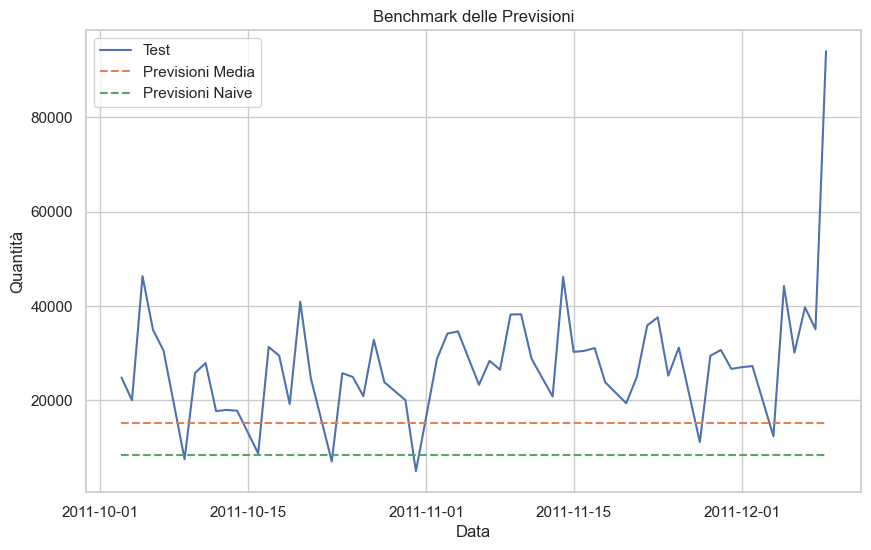

In [88]:
# Benchmarks
media_train = y_train.mean()
previsioni_media = np.full(len(y_test), media_train)
rmse_media = np.sqrt(mean_squared_error(y_test, previsioni_media))

ultimo_valore_train = y_train.iloc[-1]
previsioni_naive = np.full(len(y_test), ultimo_valore_train)
rmse_naive = np.sqrt(mean_squared_error(y_test, previsioni_naive))

plot_benchmarks(y_test, previsioni_media, previsioni_naive)

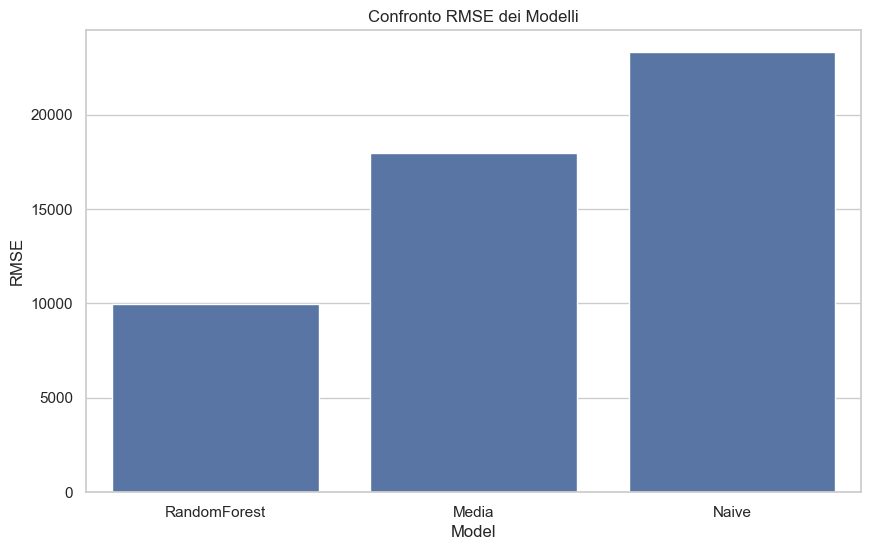

          Model          RMSE
0  RandomForest   9995.735952
1         Media  17975.296811
2         Naive  23301.852672


In [89]:
benchmark_data = pd.DataFrame({
    'Model': ['RandomForest', 'Media', 'Naive'],
    'RMSE': [rmse, rmse_media, rmse_naive]
})

plot_benchmark_comparison(benchmark_data)
print(benchmark_data)

<h4><b>Considerazioni:</b></h4>
<ul>
    <li>Il grafico confronta RMSE, di tre modelli: RandomForest, Media e Naive. Dopo un attenta analisi possiamo affermare che il modello RandomForest ha RMSE più basso, indicando che è il modello più accurato tra i tre. Il modello Naive ha RMSE più alto, suggerendo che è il meno accurato. Il modello della Media si posiziona a metà. Questo suggerisce che il RandomForest è un buon modello per questo tipo di previsione.</li>
</ul>

<h1><b>5. Valutazione</b></h1>
<h4><b>5.1. Metriche di Valutazione</b></h2>
Definisci le metriche: Spiega quali metriche hai utilizzato per misurare le prestazioni del tuo modello o sistema. Ad esempio:
Accuratezza: Quanto spesso il modello fa previsioni corrette.
Precisione: Quanta parte delle previsioni positive sono effettivamente corrette.
Richiamo (Recall): Quanta parte dei veri positivi sono stati correttamente identificati.
F1-score: Media armonica di precisione e richiamo.
AUC-ROC: Area sotto la curva Receiver Operating Characteristic, misura la capacità di distinguere tra classi.
MSE (Errore Quadratico Medio): Misura la differenza media tra valori predetti e valori reali.
RMSE (Radice dell'Errore Quadratico Medio): Radice quadrata dell'MSE, più interpretabile.
Giustifica le scelte: Spiega perché hai scelto quelle specifiche metriche. Ad esempio, se hai un problema di classificazione sbilanciato, potresti concentrarti su precisione, richiamo e F1-score piuttosto che sulla sola accuratezza.
Descrivi il processo: Spiega come hai calcolato le metriche. Hai usato cross-validation? Hai diviso i dati in training e test set?
<h4><b>5.2. Risultati</b></h2>
Qui devi presentare i risultati ottenuti in modo chiaro e organizzato.

Tabelle e grafici: Utilizza tabelle e grafici per visualizzare i risultati. Evidenzia i valori migliori e peggiori.
Confronto: Se hai confrontato diversi modelli o sistemi, mostra i risultati di tutti in modo comparativo.
Analisi: Non limitarti a mostrare i numeri, ma analizza i risultati. Cosa significano? Il modello è efficace? Ci sono aree in cui il modello performa meglio o peggio?
Esempio:*
"Il modello Random Forest ha ottenuto un'accuratezza del 95% sul set di test, superando il modello di regressione logistica che ha raggiunto l'88%."
"L'F1-score del modello è di 0.82, indicando un buon equilibrio tra precisione e richiamo."
"Il grafico mostra che il modello ha difficoltà a classificare correttamente la classe minoritaria."
<h4><b>5.3. Conclusioni</b></h2>
In questa sezione, devi sintetizzare i risultati ottenuti e trarre conclusioni sul tuo lavoro.

Riassunto: Riassumi brevemente i risultati principali.
Interpretazione: Interpreta i risultati alla luce degli obiettivi che ti eri posto. Hai raggiunto gli obiettivi? Il modello è efficace?
Limiti: Riconosci i limiti del tuo lavoro. Ci sono aspetti che potrebbero essere migliorati? Hai fatto delle assunzioni che potrebbero influenzare i risultati?
Implicazioni: Discuti le implicazioni dei tuoi risultati. Quali sono le applicazioni pratiche? Quali sono le implicazioni teoriche?
Lavori futuri: Suggerisci possibili sviluppi futuri del tuo lavoro. Ci sono esperimenti o analisi che potrebbero essere condotti in seguito?